![SolasAI Banner Image](../images/SolasAI-Logo.png)

<br>

# SolasAI Disparity Calculations

In [1]:
import solas_disparity as sd
import pandas as pd

It's preferable to explicitly and specifically handle warnings. For the
purposes of this notebook, we will filter out all warnings.

In [2]:
from warnings import simplefilter
simplefilter("ignore")

Some predictions were created using a tree model run on an HMDA dataset.

In [3]:
label = "Interest Rate"
data = pd.read_parquet("data/hmda_test.parquet")

Store commonly reused function arguments.

In [4]:
protected_groups = ["Black", "Asian", "Native American", "Hispanic", "Female"]
reference_groups = ["White", "White", "White", "Non-Hispanic", "Male"]
groups = sd.pgrg_ordered(
    protected_groups=protected_groups,
    reference_groups=reference_groups,
)
reused_arguments = dict(
    group_data=data[groups],
    protected_groups=protected_groups,
    reference_groups=reference_groups,
    group_categories=["Race", "Race", "Race", "Ethnicity", "Sex"],
    sample_weight=None,
)
binary_outcome = data["Prediction"] <= data["Prediction"].quantile(0.5)
binary_label = data[label] <= data[label].quantile(0.5)

## Adverse Impact Ratio (AIR)

In [5]:
air = sd.adverse_impact_ratio(
    outcome=binary_outcome,
    air_threshold=0.8,
    percent_difference_threshold=0.0,
    **reused_arguments,
)

## Disparity Calculation: Adverse Impact Ratio

┌───────────────────────────────────────────┬─────────────────────────────────────────────────────────────────────┐
│ Protected Groups                          │ Black, Asian, Native American, Hispanic, Female                     │
│ Reference Groups                          │ White, White, White, Non-Hispanic, Male                             │
│ Group Categories                          │ Race, Race, Race, Ethnicity, Sex                                    │
│ AIR Threshold                             │ 0.8                                                                 │
│ Percent Difference Threshold              │ 0.0                                                                 │
│ Shortfall Method                          │ to_reference_mean                                                   │
│ Affected Groups                           │ Hispanic                                                            │
│ Affected Reference                        │ Non-Hispanic                                                        │
│ Affected Categories                       │ Ethnicity                                                           │
└───────────────────────────────────────────┴─────────────────────────────────────────────────────────────────────┘

## Adverse Impact Ratio Summary Table

\* Percent Missing: Ethnicity: 13.68%, Race: 13.56%, Sex: 46.88%

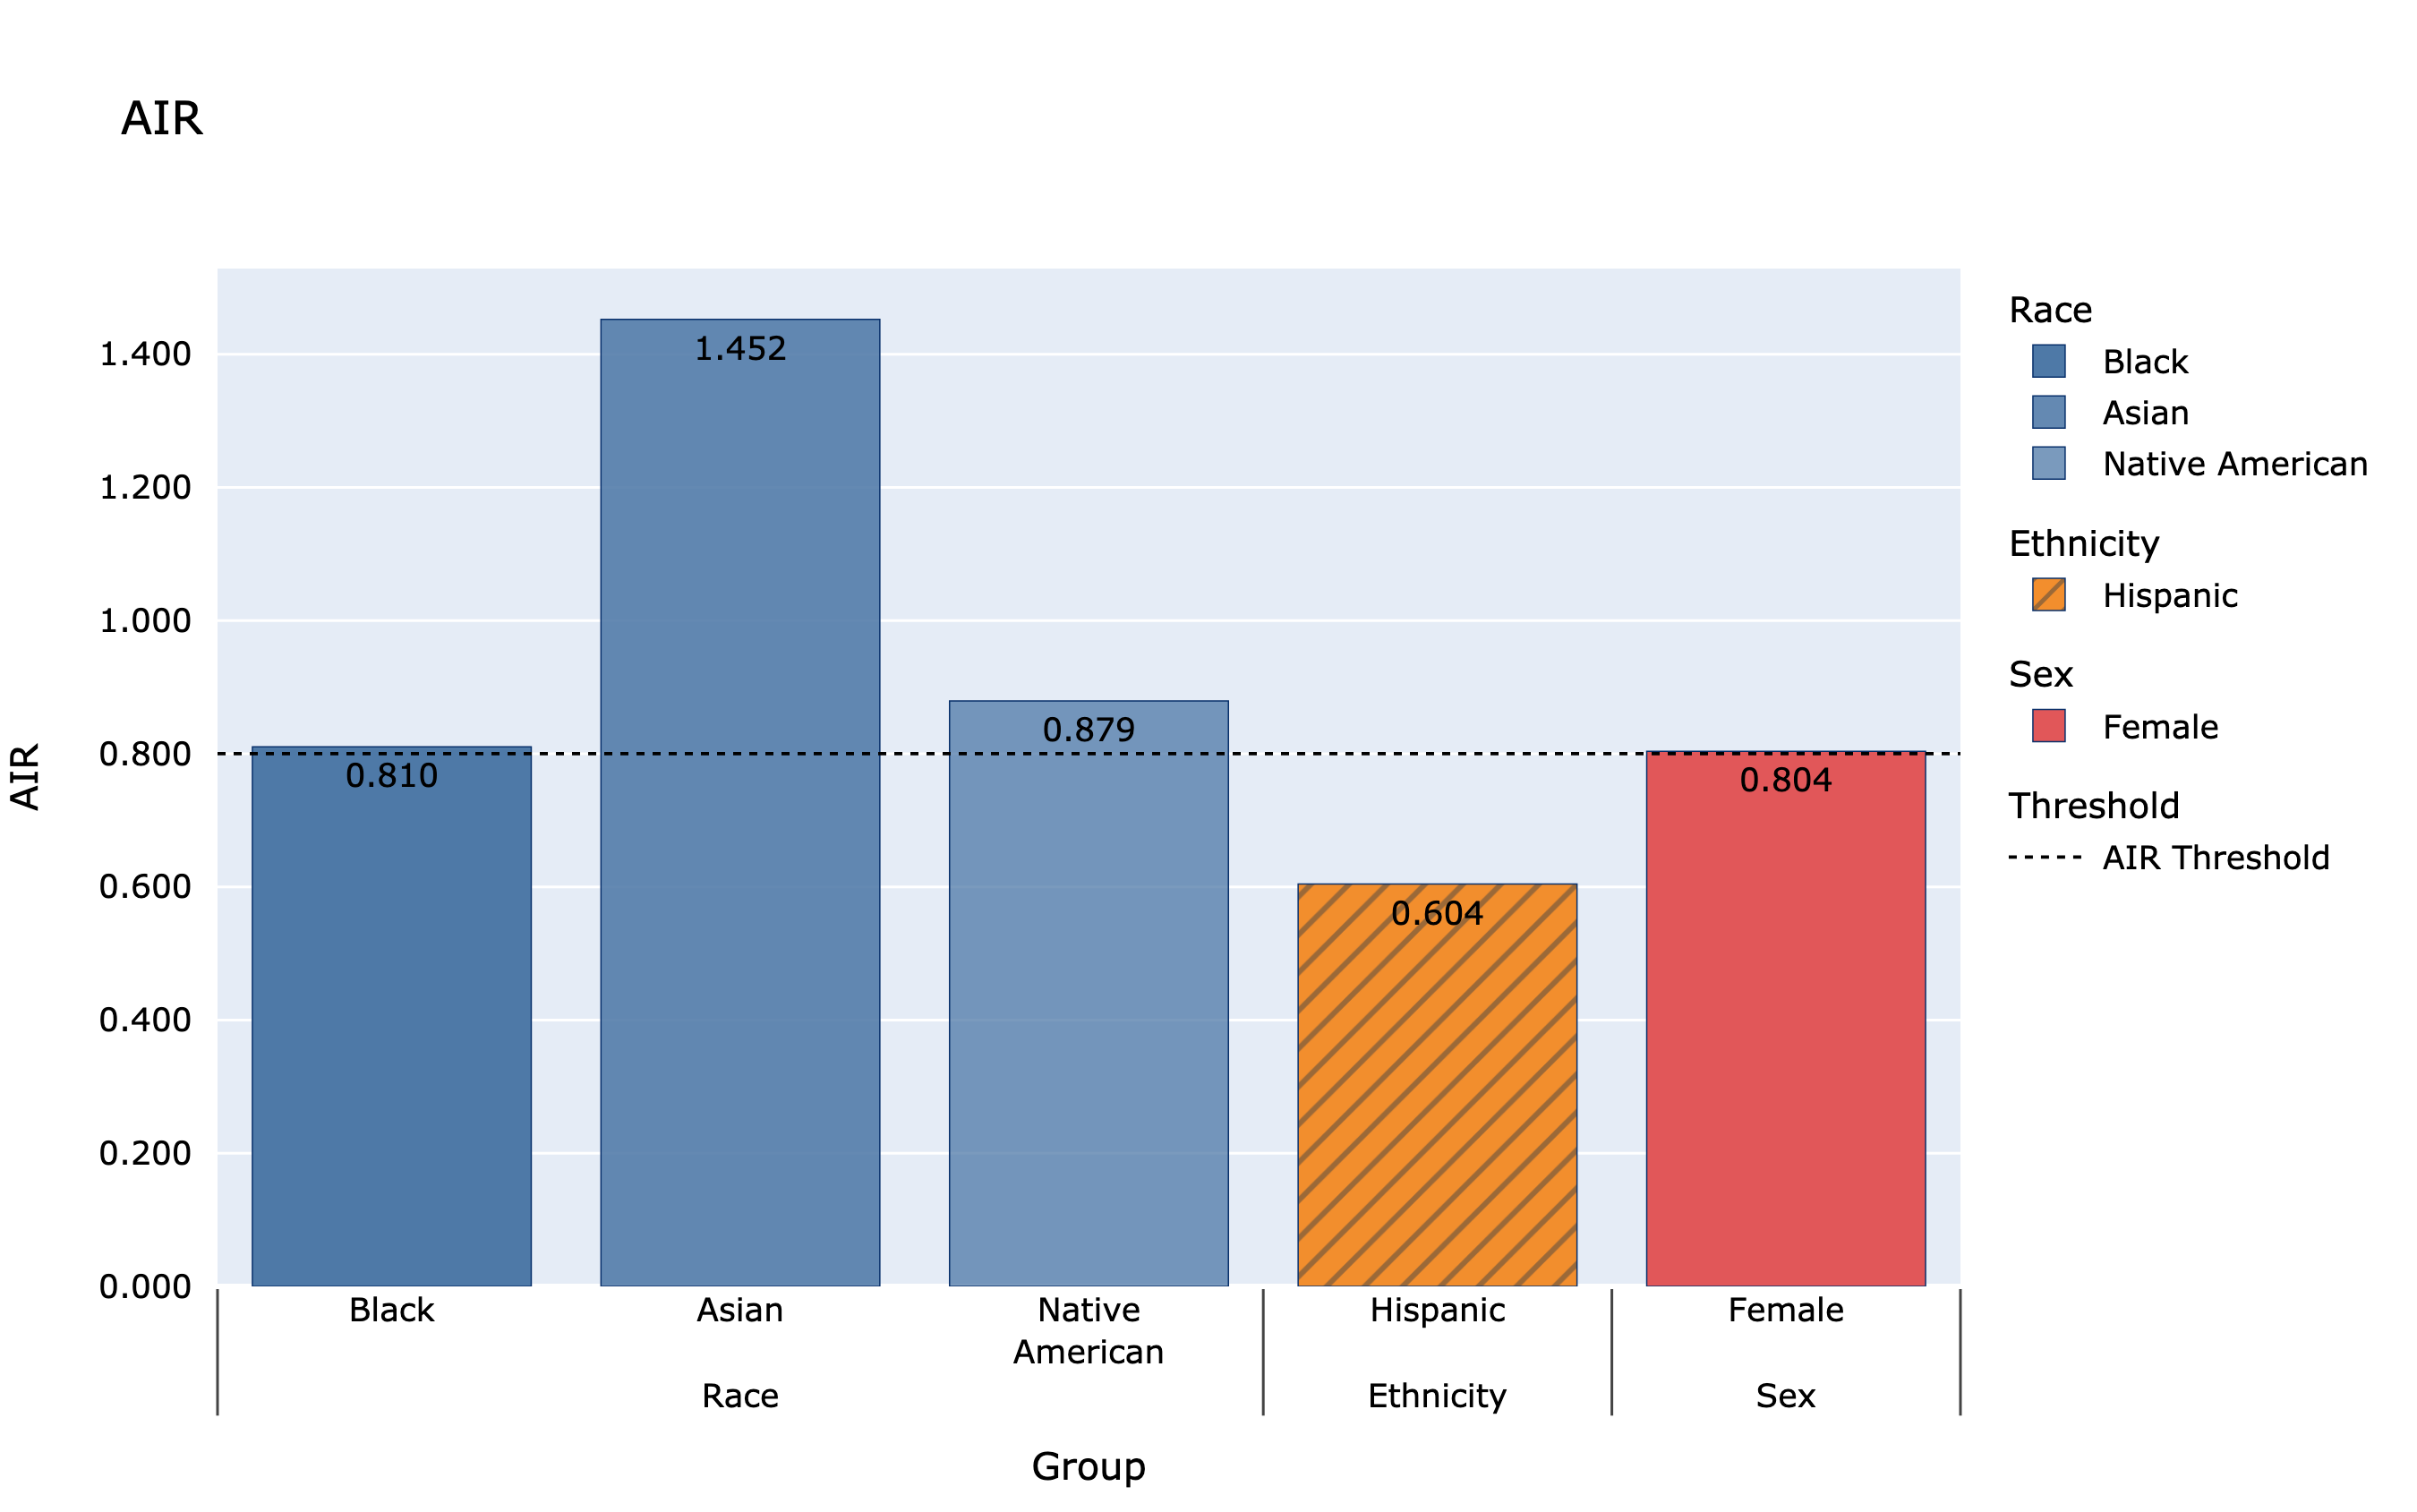

In [6]:
air

## Standardized Mean Difference (SMD)

In [7]:
smd = sd.standardized_mean_difference(
    outcome=data["Prediction"],
    label=data[label],
    smd_threshold=30,
    lower_score_favorable=True,
    **reused_arguments,
)

## Disparity Calculation: Standardized Mean Difference

┌────────────────────────────────────┬────────────────────────────────────────────────────────────────────────────┐
│ Protected Groups                   │ Black, Asian, Native American, Hispanic, Female                            │
│ Reference Groups                   │ White, White, White, Non-Hispanic, Male                                    │
│ Group Categories                   │ Race, Race, Race, Ethnicity, Sex                                           │
│ SMD Threshold                      │ 30.0                                                                       │
│ SMD Denominator                    │ population                                                                 │
│ Lower Score Favorable              │ True                                                                       │
│ Affected Groups                    │ Hispanic                                                                   │
│ Affected Reference                 │ Non-Hispanic                                                               │
│ Affected Categories                │ Ethnicity                                                                  │
└────────────────────────────────────┴────────────────────────────────────────────────────────────────────────────┘

## Standardized Mean Difference Summary Table

\* Percent Missing: Ethnicity: 13.68%, Race: 13.56%, Sex: 46.88%

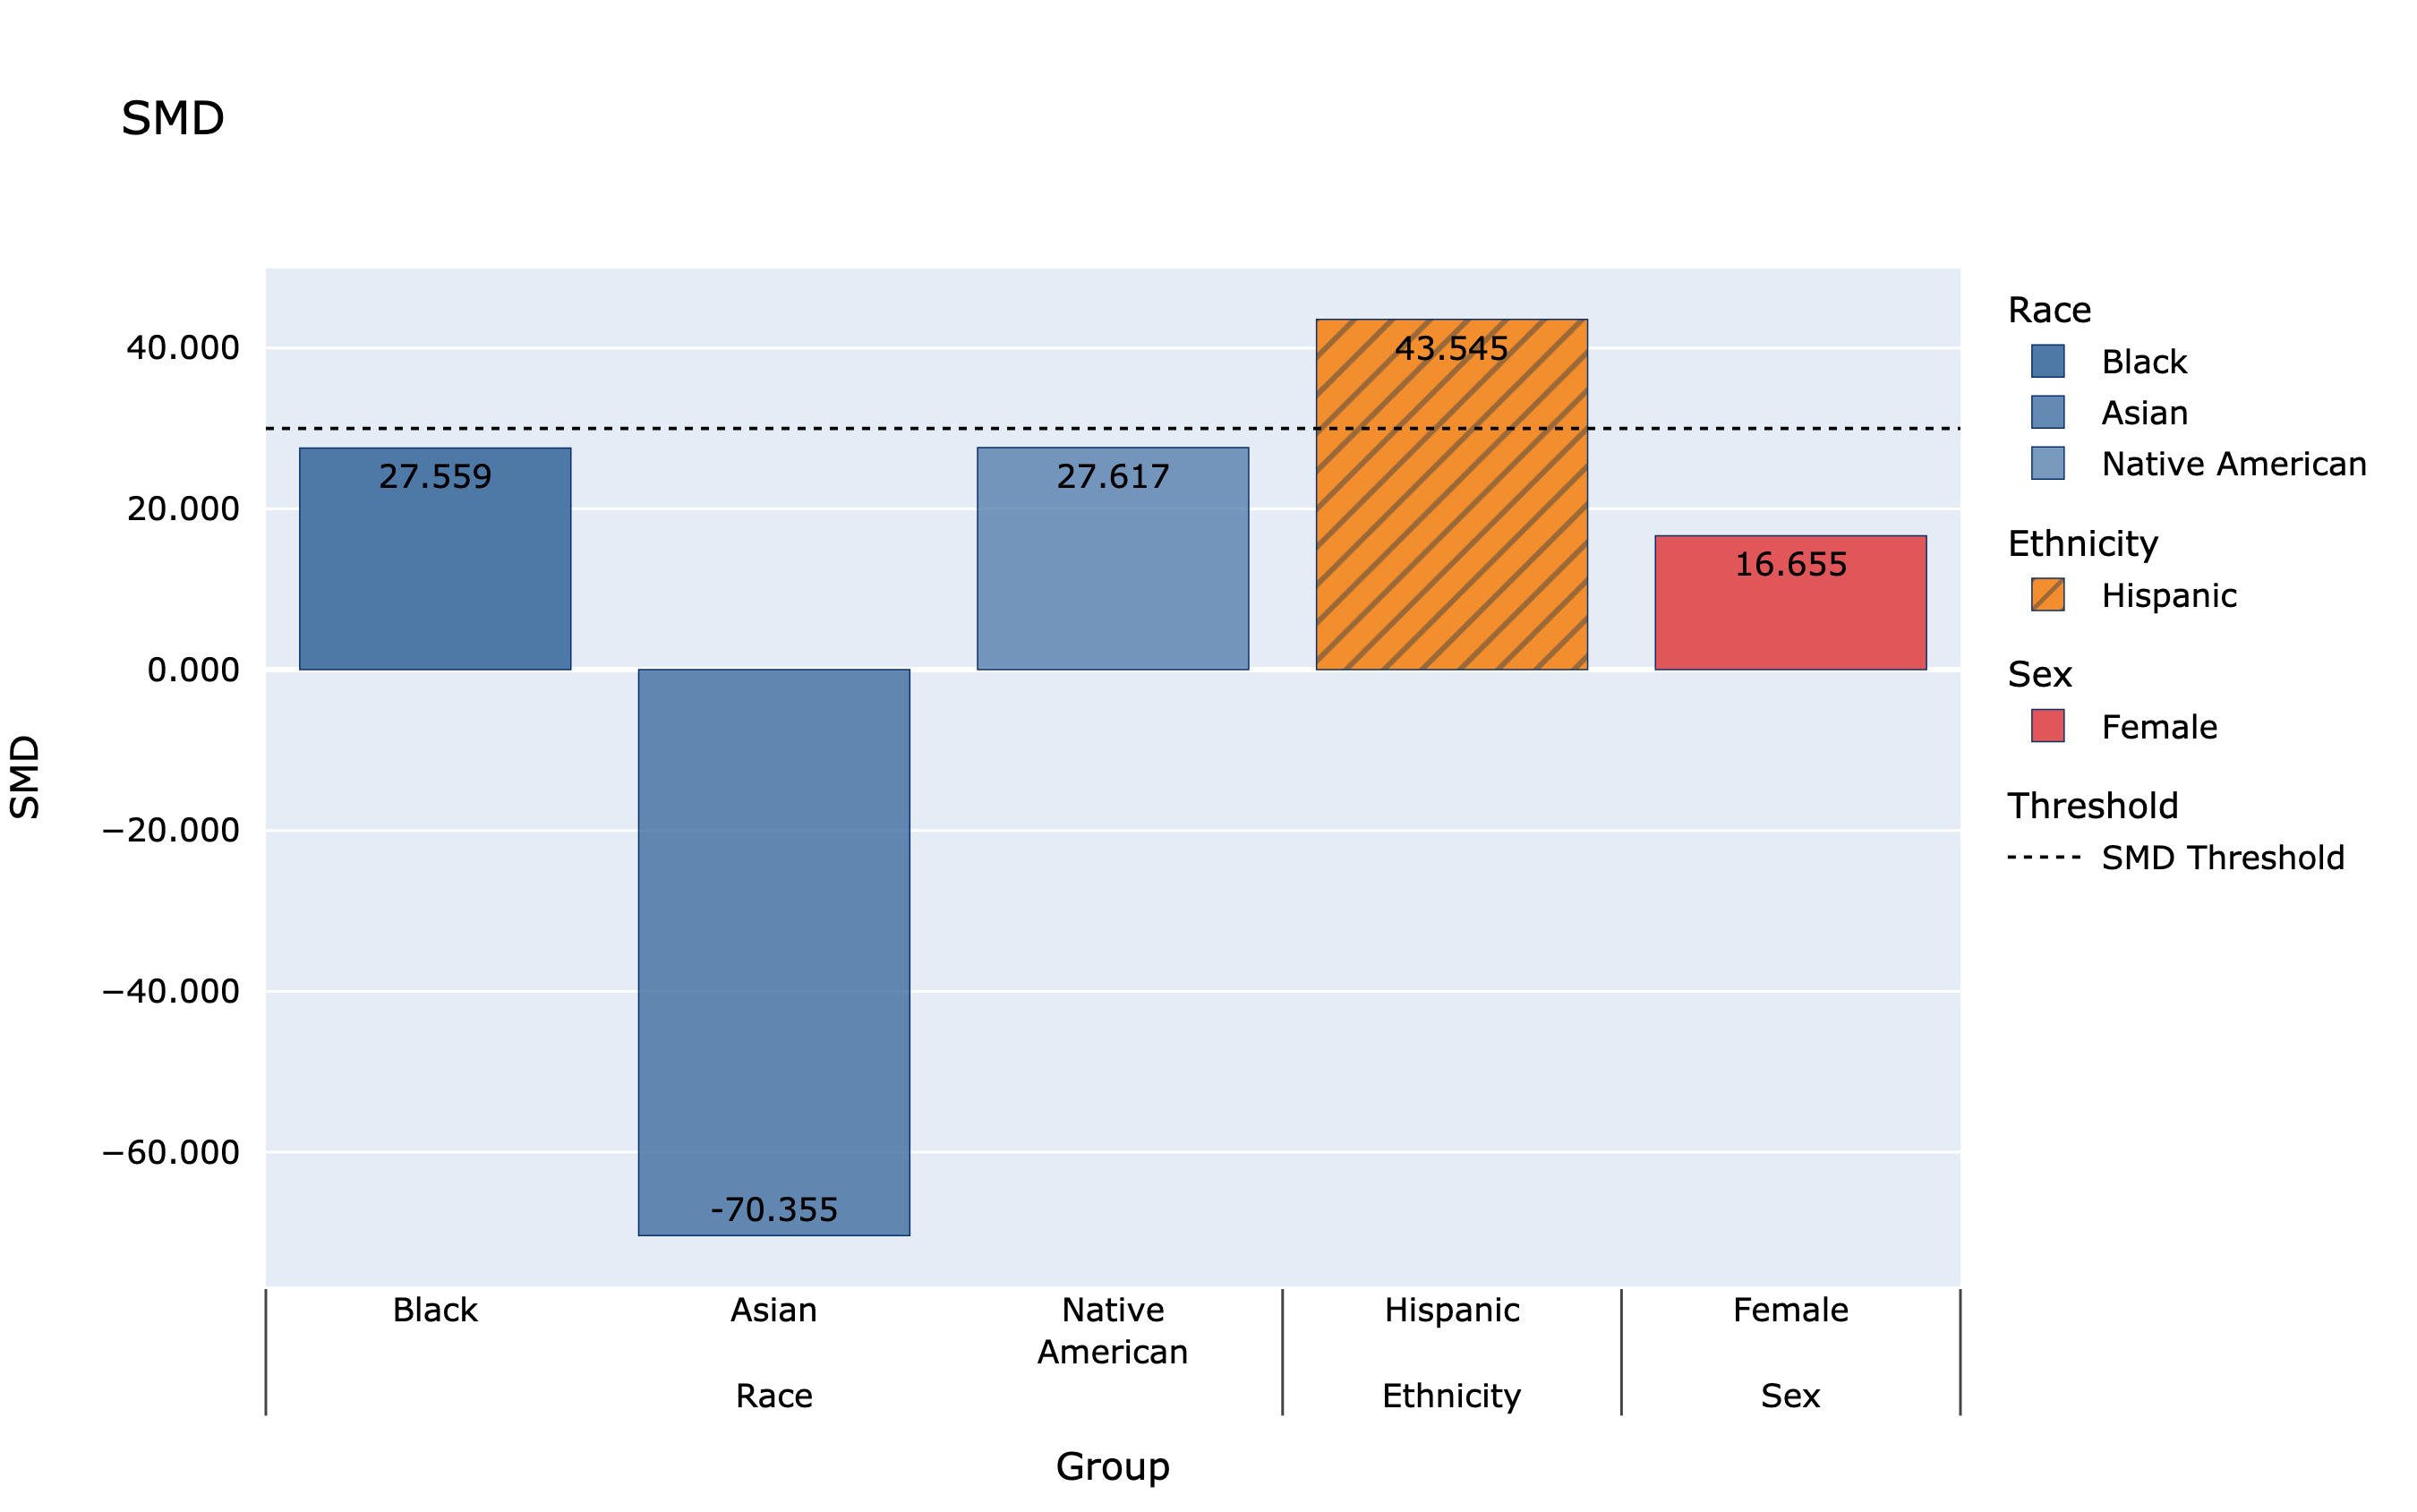

In [8]:
smd

## Adverse Impact Ratio by Quantile

In [9]:
airq = sd.adverse_impact_ratio_by_quantile(
    outcome=data["Prediction"],
    air_threshold=0.8,
    percent_difference_threshold=0.0,
    quantiles=[decile / 10 for decile in range(1, 11)],
    lower_score_favorable=True,
    **reused_arguments,
)

## Disparity Calculation: Adverse Impact Ratio By Quantile

┌───────────────────────────────────────────┬─────────────────────────────────────────────────────────────────────┐
│ Protected Groups                          │ Black, Asian, Native American, Hispanic, Female                     │
│ Reference Groups                          │ White, White, White, Non-Hispanic, Male                             │
│ Group Categories                          │ Race, Race, Race, Ethnicity, Sex                                    │
│ AIR Threshold                             │ 0.8                                                                 │
│ Percent Difference Threshold              │ 0.0                                                                 │
│ Lower Score Favorable                     │ True                                                                │
│ Affected Groups                           │ Black, Hispanic, Female                                             │
│ Affected Reference                        │ White, Non-Hispanic, Male                                           │
│ Affected Categories                       │ Race, Ethnicity, Sex                                                │
└───────────────────────────────────────────┴─────────────────────────────────────────────────────────────────────┘

## Adverse Impact Ratio By Quantile Summary Table

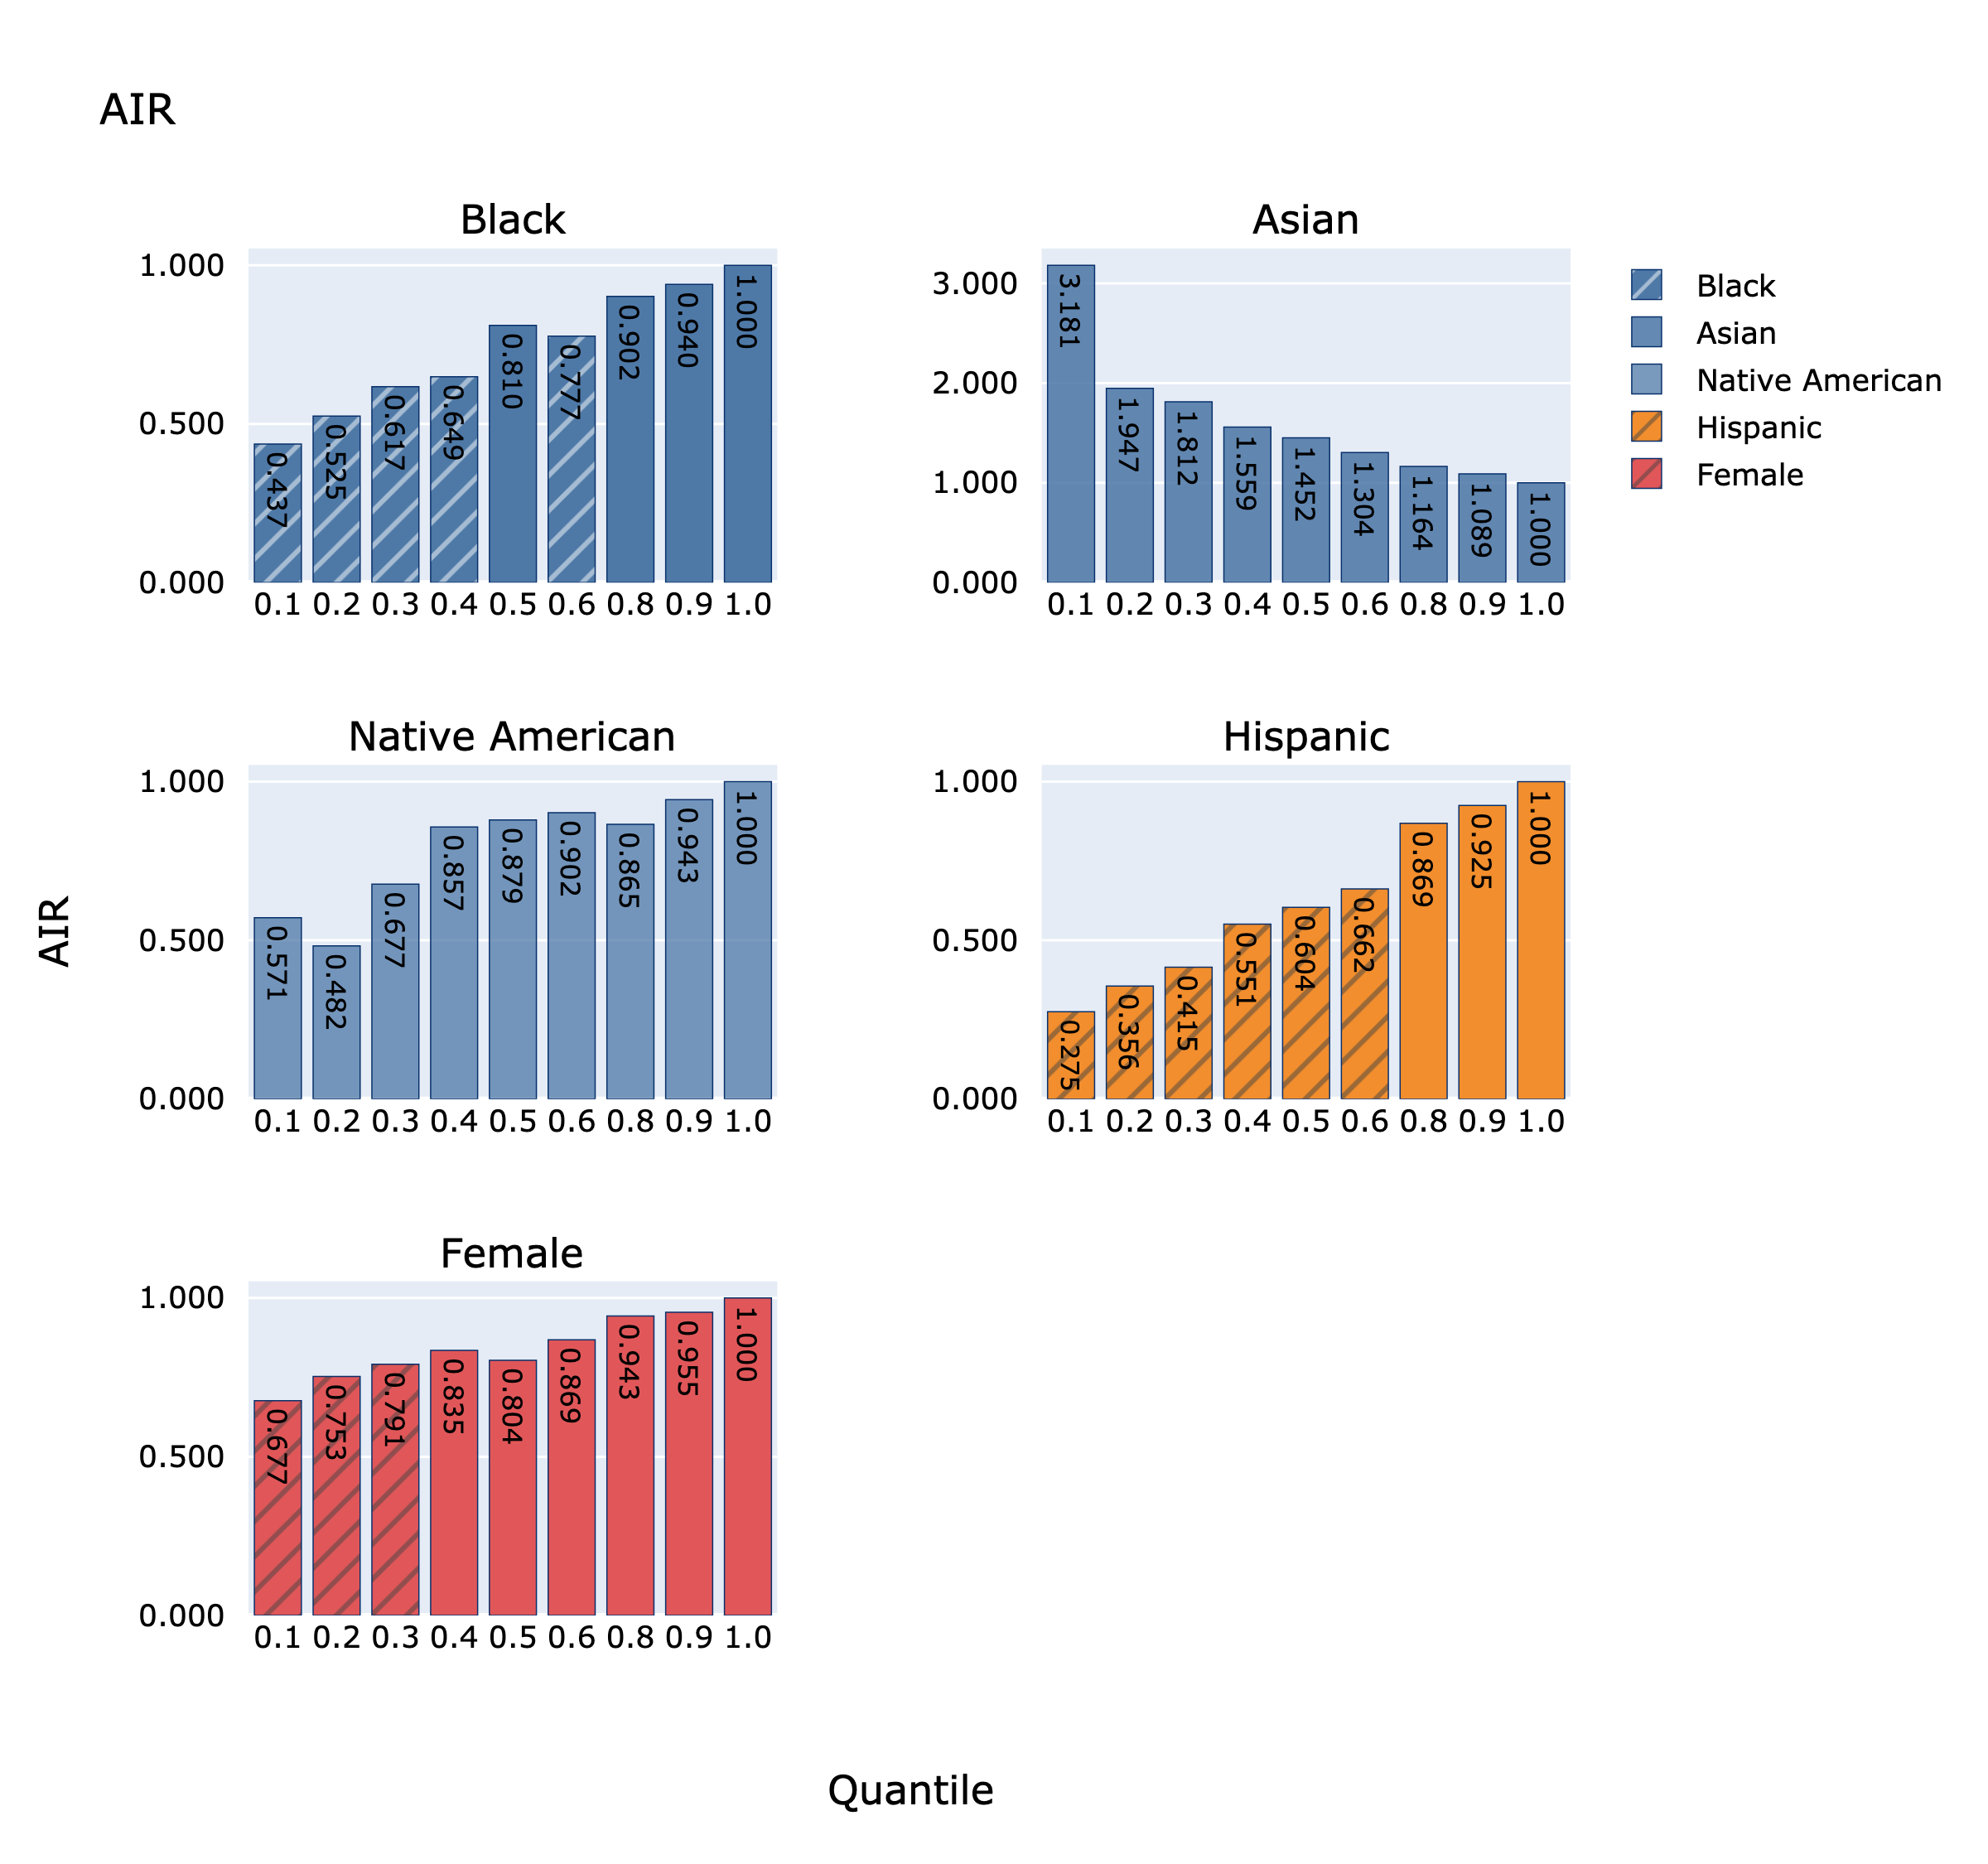

In [10]:
airq

## Odds Ratio

In [11]:
odds_ratio = sd.odds_ratio(
    outcome=binary_outcome,
    odds_ratio_threshold=0.68,
    percent_difference_threshold=0.0,
    **reused_arguments,
)

## Disparity Calculation: Odds Ratio

┌───────────────────────────────────────────┬─────────────────────────────────────────────────────────────────────┐
│ Protected Groups                          │ Black, Asian, Native American, Hispanic, Female                     │
│ Reference Groups                          │ White, White, White, Non-Hispanic, Male                             │
│ Group Categories                          │ Race, Race, Race, Ethnicity, Sex                                    │
│ Odds Ratio Threshold                      │ 0.68                                                                │
│ Percent Difference Threshold              │ 0.0                                                                 │
│ Lower Score Favorable                     │ True                                                                │
│ Affected Groups                           │ Black, Hispanic, Female                                             │
│ Affected Reference                        │ White, Non-Hispanic, Male                                           │
│ Affected Categories                       │ Race, Ethnicity, Sex                                                │
└───────────────────────────────────────────┴─────────────────────────────────────────────────────────────────────┘

## Odds Ratio Summary Table

\* Percent Missing: Ethnicity: 13.68%, Race: 13.56%, Sex: 46.88%

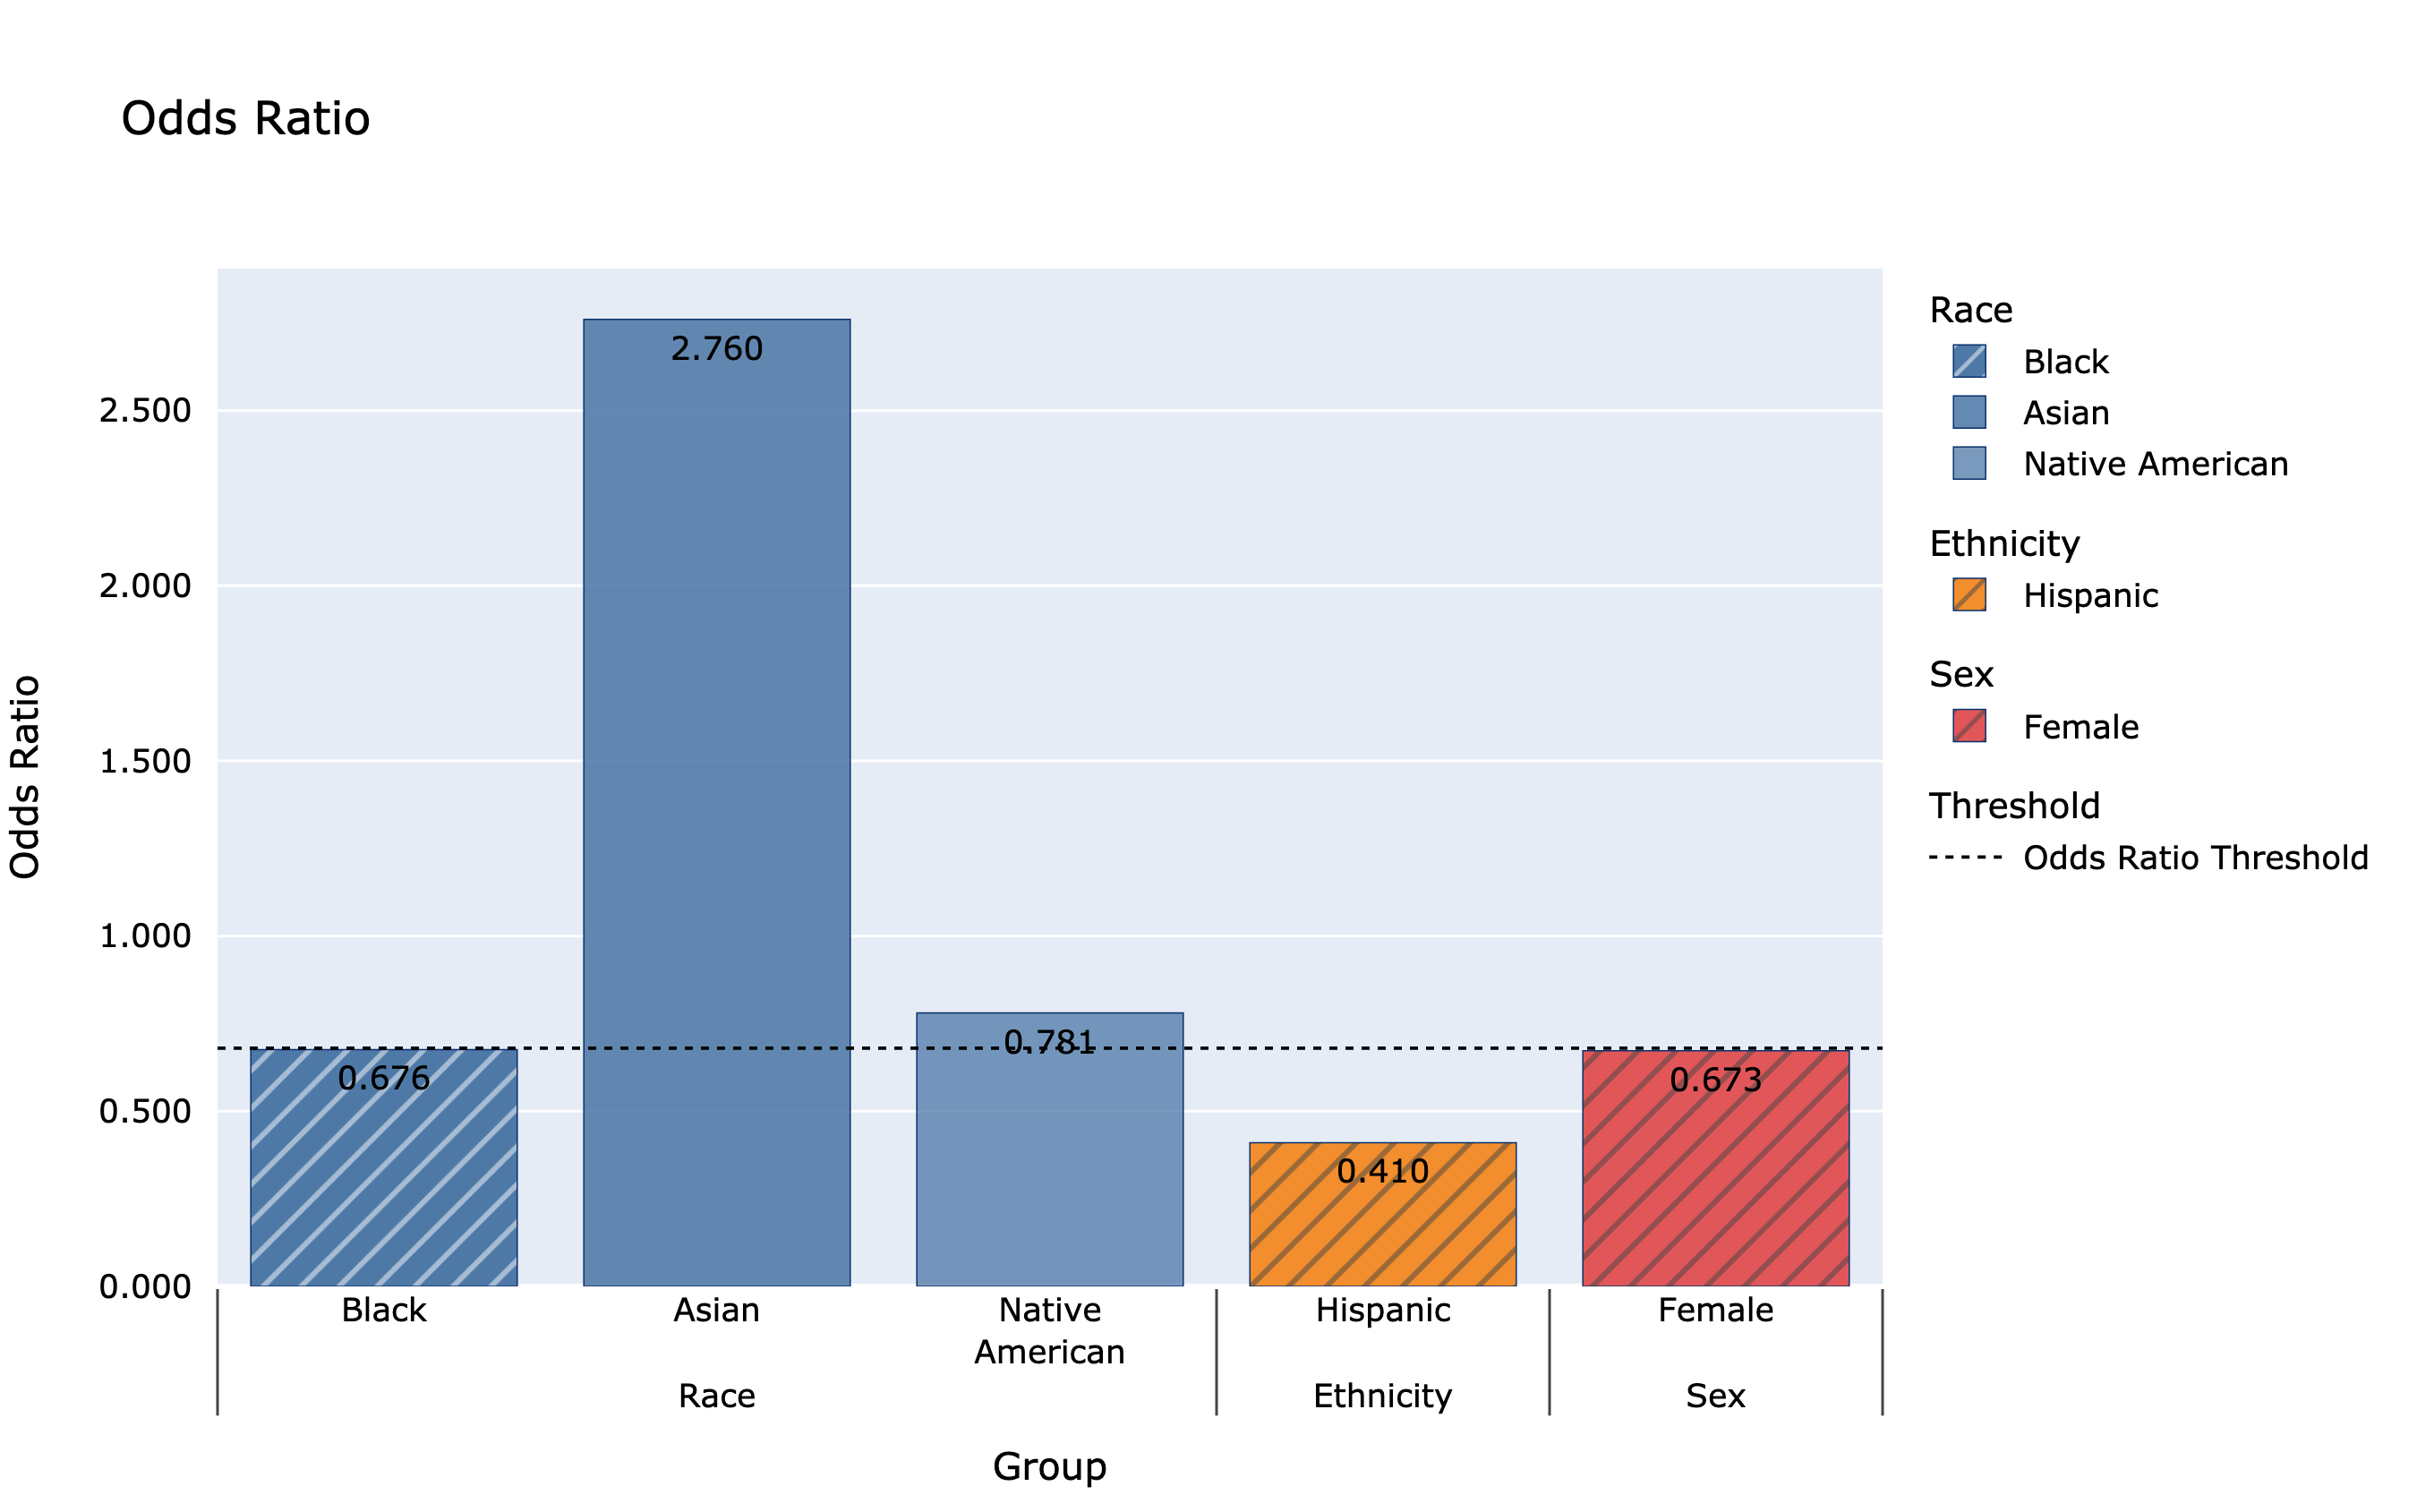

In [12]:
odds_ratio

## Categorical Adverse Impact Ratio

In [13]:
# Generate an example categorical outcome.
categorical_outcome = pd.qcut(data["Prediction"], q=[0.0, 0.25, 0.5, 0.75, 1.0])
categories = categorical_outcome.cat.categories.to_series()
categories = pd.Series(["Best", "Great", "Good", "Bad"], index=categories.index)
categorical_outcome.replace(categories.to_dict(), inplace=True)

In [14]:
cair = sd.categorical_adverse_impact_ratio(
    outcome=categorical_outcome,
    category_order=list(reversed(categories.tolist())),
    air_threshold=0.8,
    percent_difference_threshold=0.0,
    **reused_arguments,
)

## Disparity Calculation: Categorical Adverse Impact Ratio

┌───────────────────────────────────────────┬─────────────────────────────────────────────────────────────────────┐
│ Protected Groups                          │ Black, Asian, Native American, Hispanic, Female                     │
│ Reference Groups                          │ White, White, White, Non-Hispanic, Male                             │
│ Group Categories                          │ Race, Race, Race, Ethnicity, Sex                                    │
│ AIR Threshold                             │ 0.8                                                                 │
│ Percent Difference Threshold              │ 0.0                                                                 │
│ Affected Groups                           │ Hispanic, Black, Female                                             │
│ Affected Reference                        │ Non-Hispanic, White, Male                                           │
│ Affected Categories                       │ Ethnicity, Race, Sex                                                │
└───────────────────────────────────────────┴─────────────────────────────────────────────────────────────────────┘

## Categorical Adverse Impact Ratio Summary Table

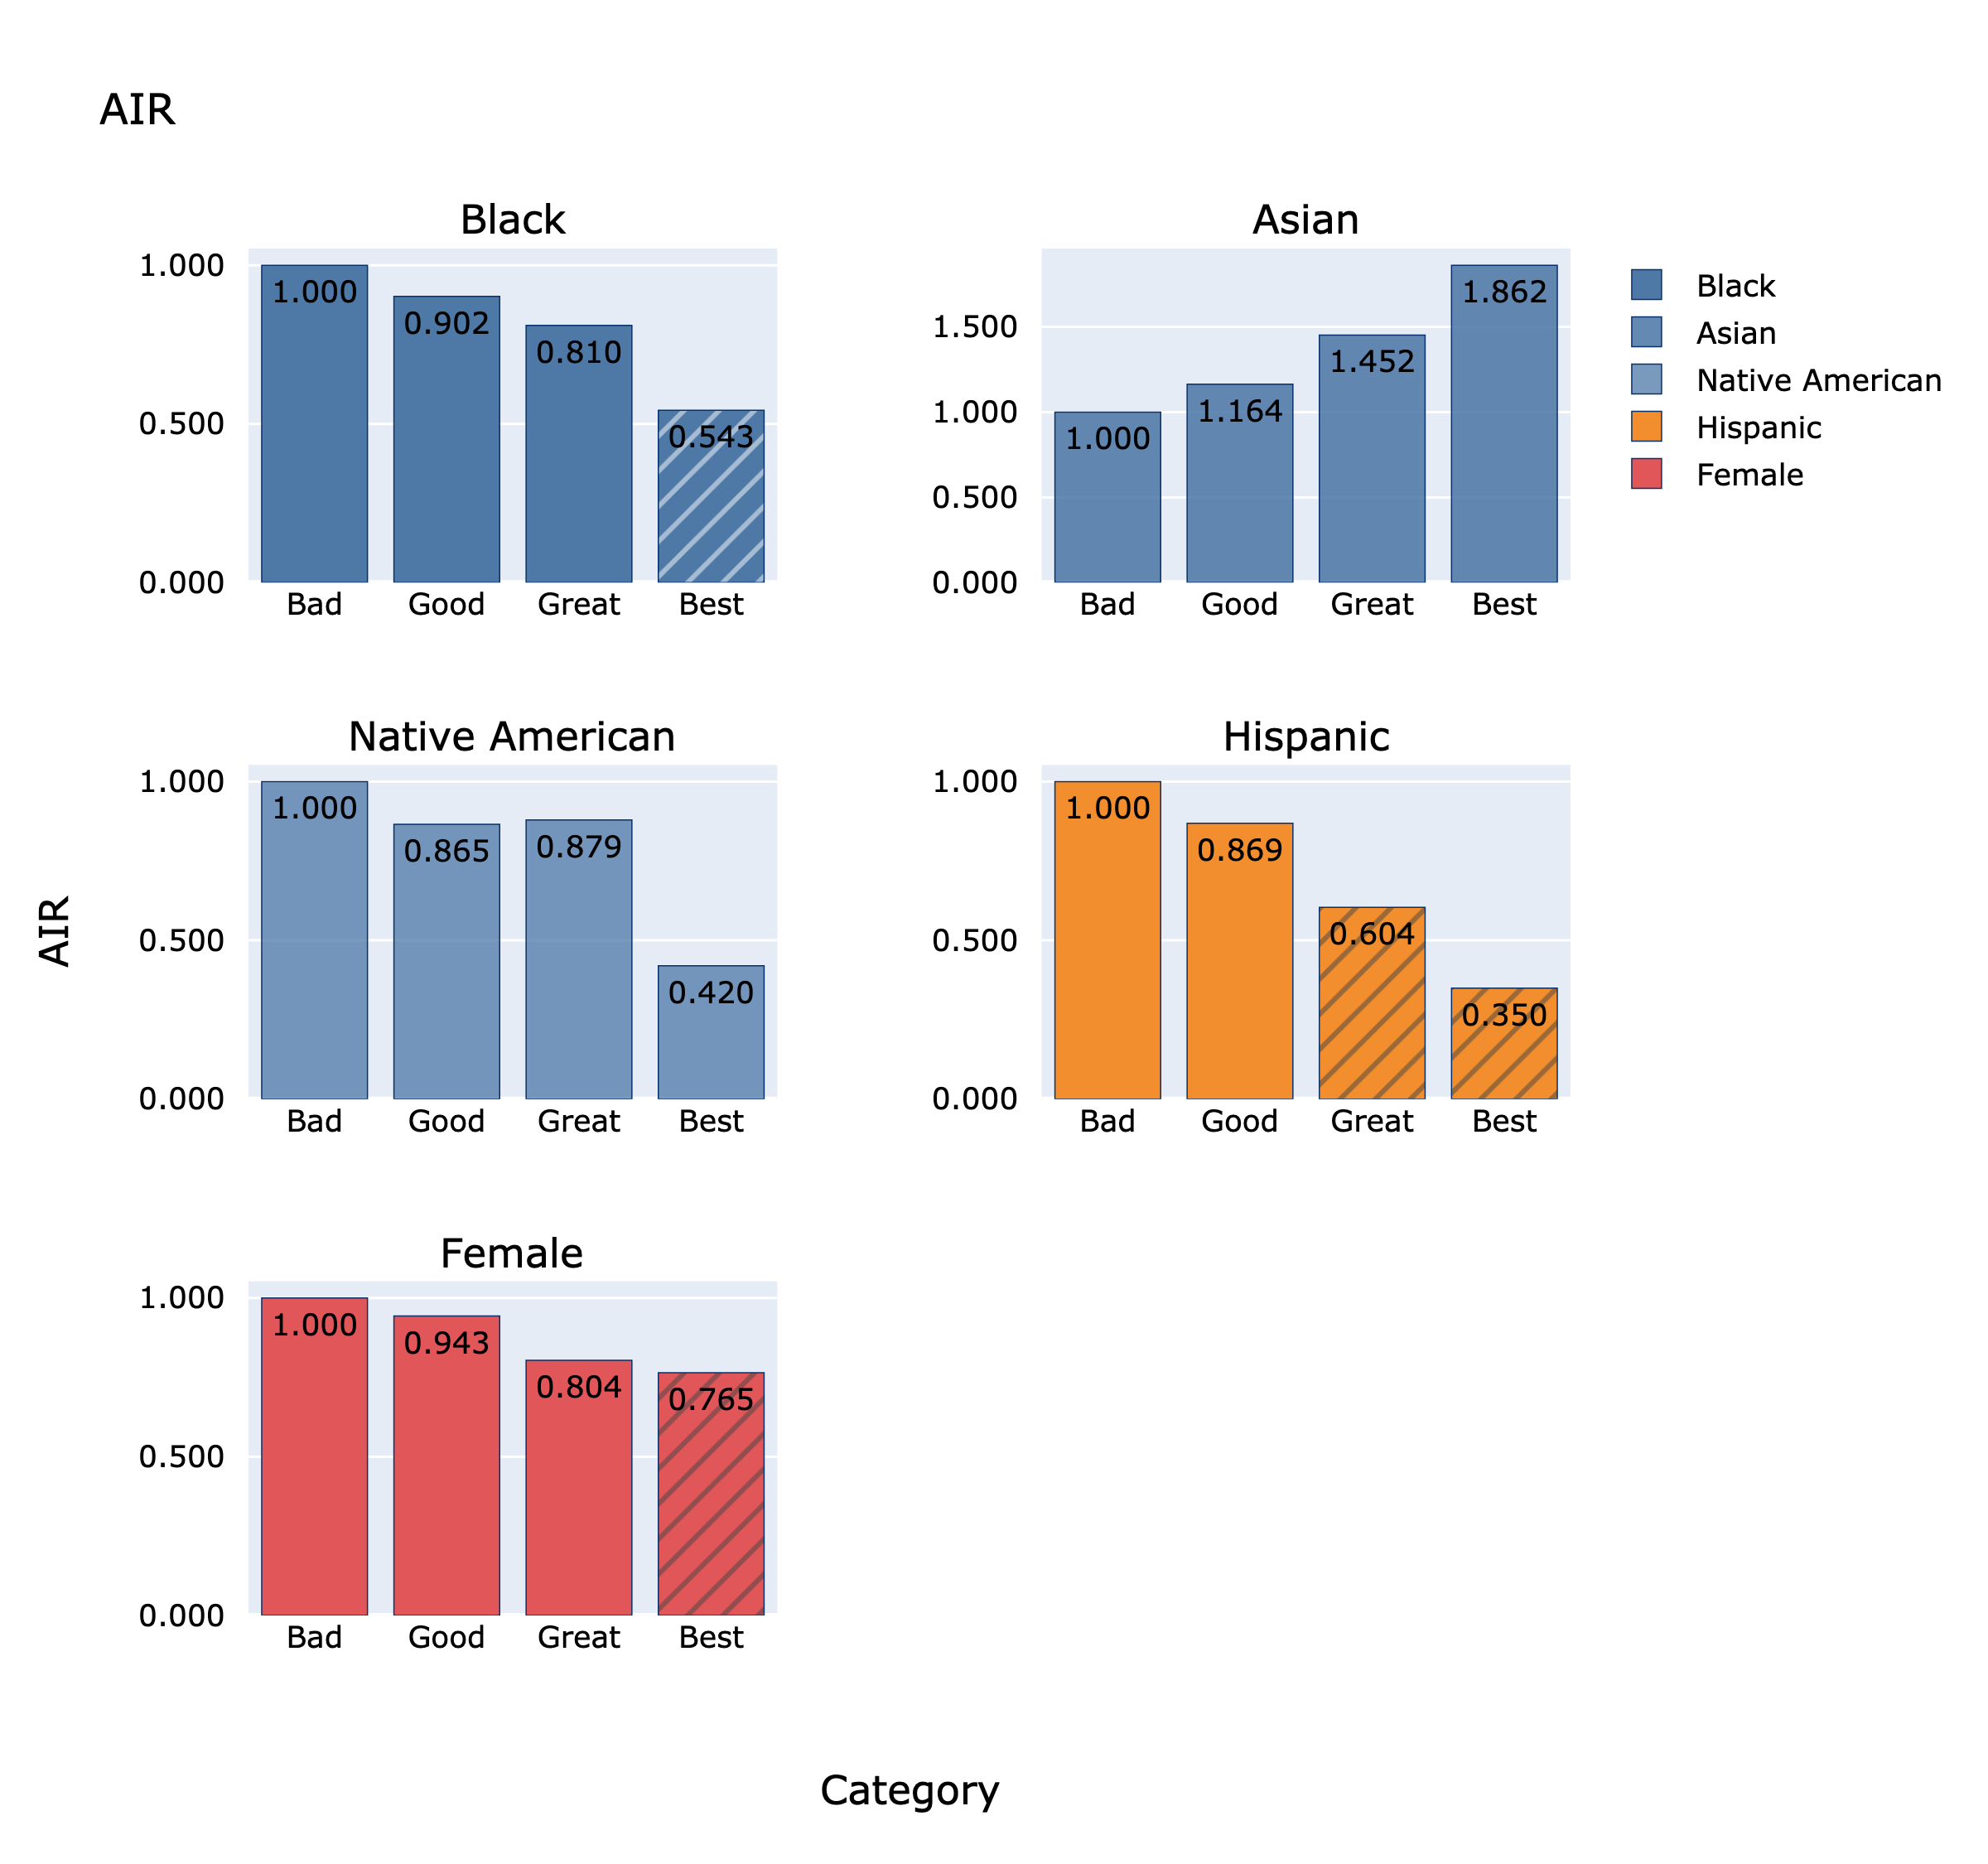

In [15]:
cair

## Residual Standardized Mean Difference

In [16]:
rsmd = sd.residual_standardized_mean_difference(
    prediction=data["Prediction"],
    label=data[label],
    residual_smd_threshold=30,
    lower_score_favorable=True,
    **reused_arguments,
)

## Disparity Calculation: Residual Standardized Mean Difference

┌───────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────┐
│ Protected Groups                      │ Black, Asian, Native American, Hispanic, Female                         │
│ Reference Groups                      │ White, White, White, Non-Hispanic, Male                                 │
│ Group Categories                      │ Race, Race, Race, Ethnicity, Sex                                        │
│ Residual SMD Threshold                │ 30.0                                                                    │
│ Residual SMD Denominator              │ population                                                              │
│ Lower Score Favorable                 │ True                                                                    │
│ Affected Groups                       │                                                                         │
│ Affected Reference                    │                                                                         │
│ Affected Categories                   │                                                                         │
└───────────────────────────────────────┴─────────────────────────────────────────────────────────────────────────┘

## Residual Standardized Mean Difference Summary Table

\* Percent Missing: Ethnicity: 13.68%, Race: 13.56%, Sex: 46.88%

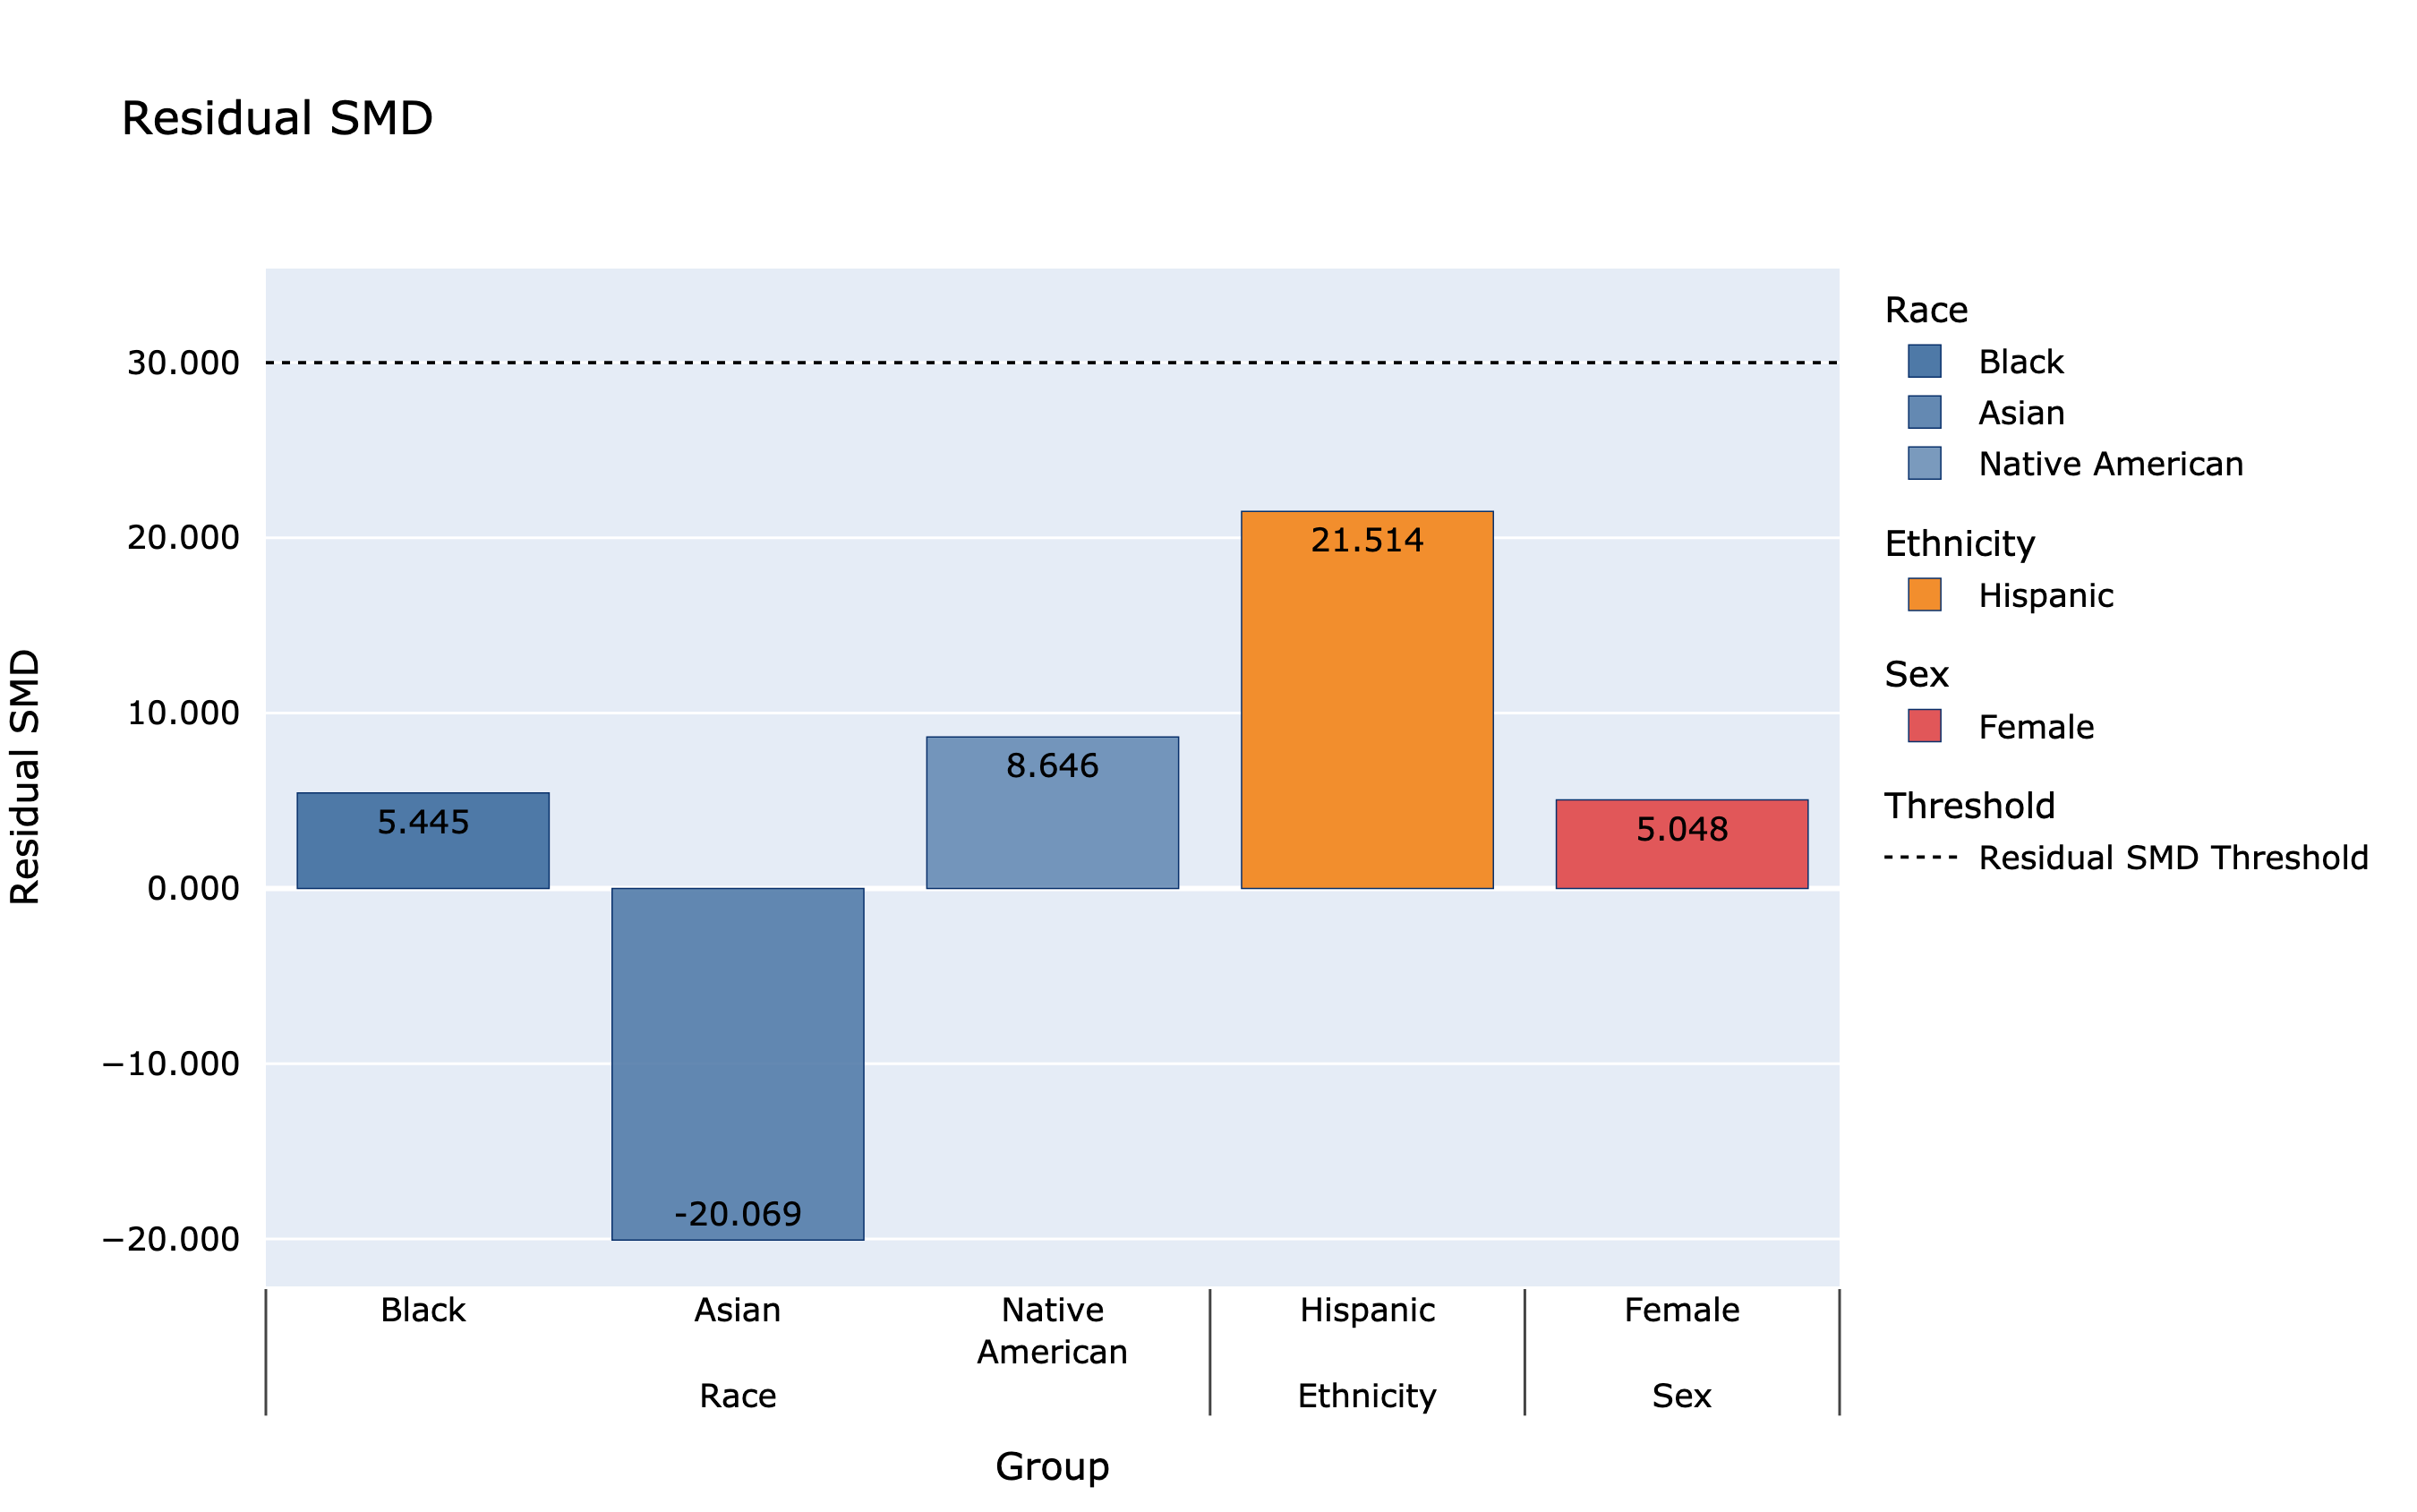

In [17]:
rsmd

## Segmented Adverse Impact Ratio

In [18]:
# Generate example income segments.
segments = pd.qcut(data["Income"], q=[0.0, 1 / 3, 2 / 3, 1.0])
categories = segments.cat.categories.to_series()
categories = pd.Series(
    ["Low Income", "Mid Income", "High Income"], index=categories.index
)
segments.replace(categories.to_dict(), inplace=True)

In [19]:
sair = sd.segmented_adverse_impact_ratio(
    outcome=binary_outcome,
    air_threshold=0.8,
    percent_difference_threshold=0.0,
    fdr_threshold=0.2,
    segment=segments,
    **reused_arguments,
)

## Disparity Calculation: Segmented Adverse Impact Ratio

┌───────────────────────────────────────────┬─────────────────────────────────────────────────────────────────────┐
│ Protected Groups                          │ Black, Asian, Native American, Hispanic, Female                     │
│ Reference Groups                          │ White, White, White, Non-Hispanic, Male                             │
│ Group Categories                          │ Race, Race, Race, Ethnicity, Sex                                    │
│ AIR Threshold                             │ 0.8                                                                 │
│ Percent Difference Threshold              │ 0.0                                                                 │
│ FDR Threshold                             │ 0.2                                                                 │
│ Affected Groups                           │ Hispanic                                                            │
│ Affected Reference                        │ Non-Hispanic                                                        │
│ Affected Categories                       │ Ethnicity                                                           │
└───────────────────────────────────────────┴─────────────────────────────────────────────────────────────────────┘

## Segmented Adverse Impact Ratio Summary Table

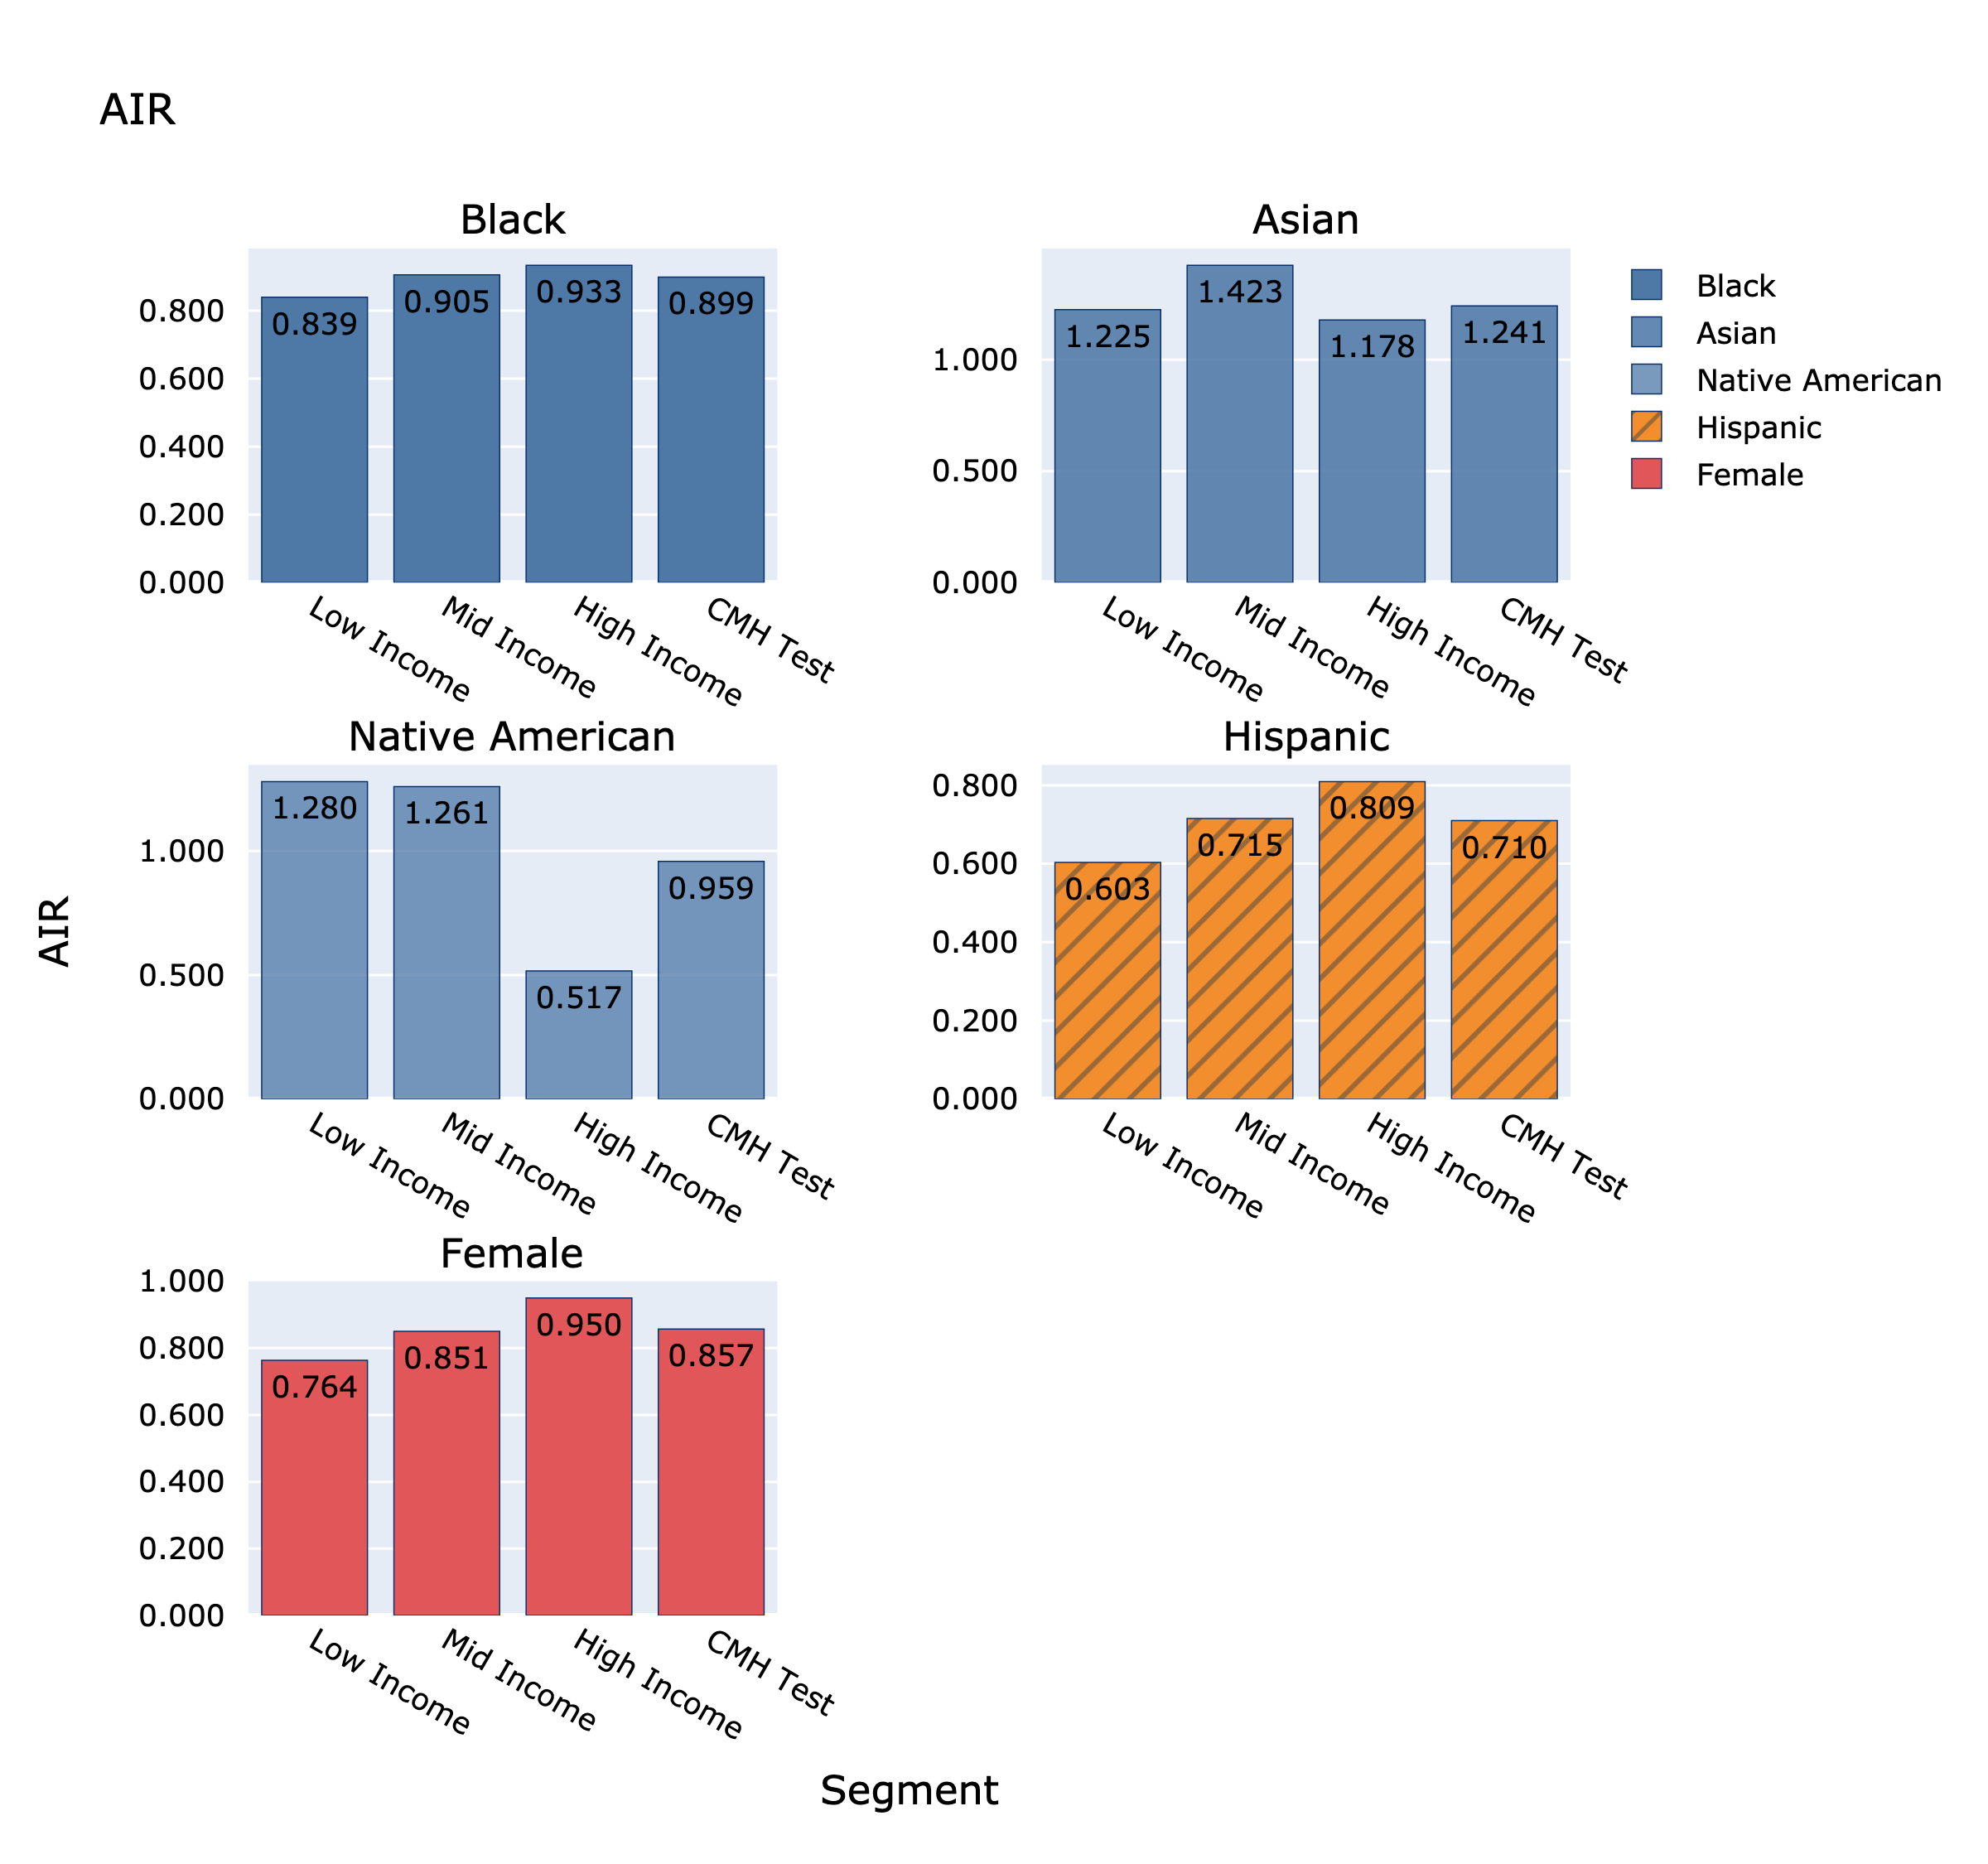

In [20]:
sair

## Relative Rate

In [21]:
rr = sd.relative_rate(
    outcome=binary_outcome,
    ratio_threshold=1.0,
    percent_difference_threshold=0.0,
    **reused_arguments,
)

## Disparity Calculation: Relative Rate

┌───────────────────────────────────────────┬─────────────────────────────────────────────────────────────────────┐
│ Protected Groups                          │ Black, Asian, Native American, Hispanic, Female                     │
│ Reference Groups                          │ White, White, White, Non-Hispanic, Male                             │
│ Group Categories                          │ Race, Race, Race, Ethnicity, Sex                                    │
│ Percent Difference Threshold              │ None                                                                │
│ Ratio Threshold                           │ 1.0                                                                 │
│ Affected Groups                           │ Black, Hispanic, Female                                             │
│ Affected Reference                        │ White, Non-Hispanic, Male                                           │
│ Affected Categories                       │ Race, Ethnicity, Sex                                                │
└───────────────────────────────────────────┴─────────────────────────────────────────────────────────────────────┘

## Relative Rate Summary Table

\* Percent Missing: Ethnicity: 13.68%, Race: 13.56%, Sex: 46.88%

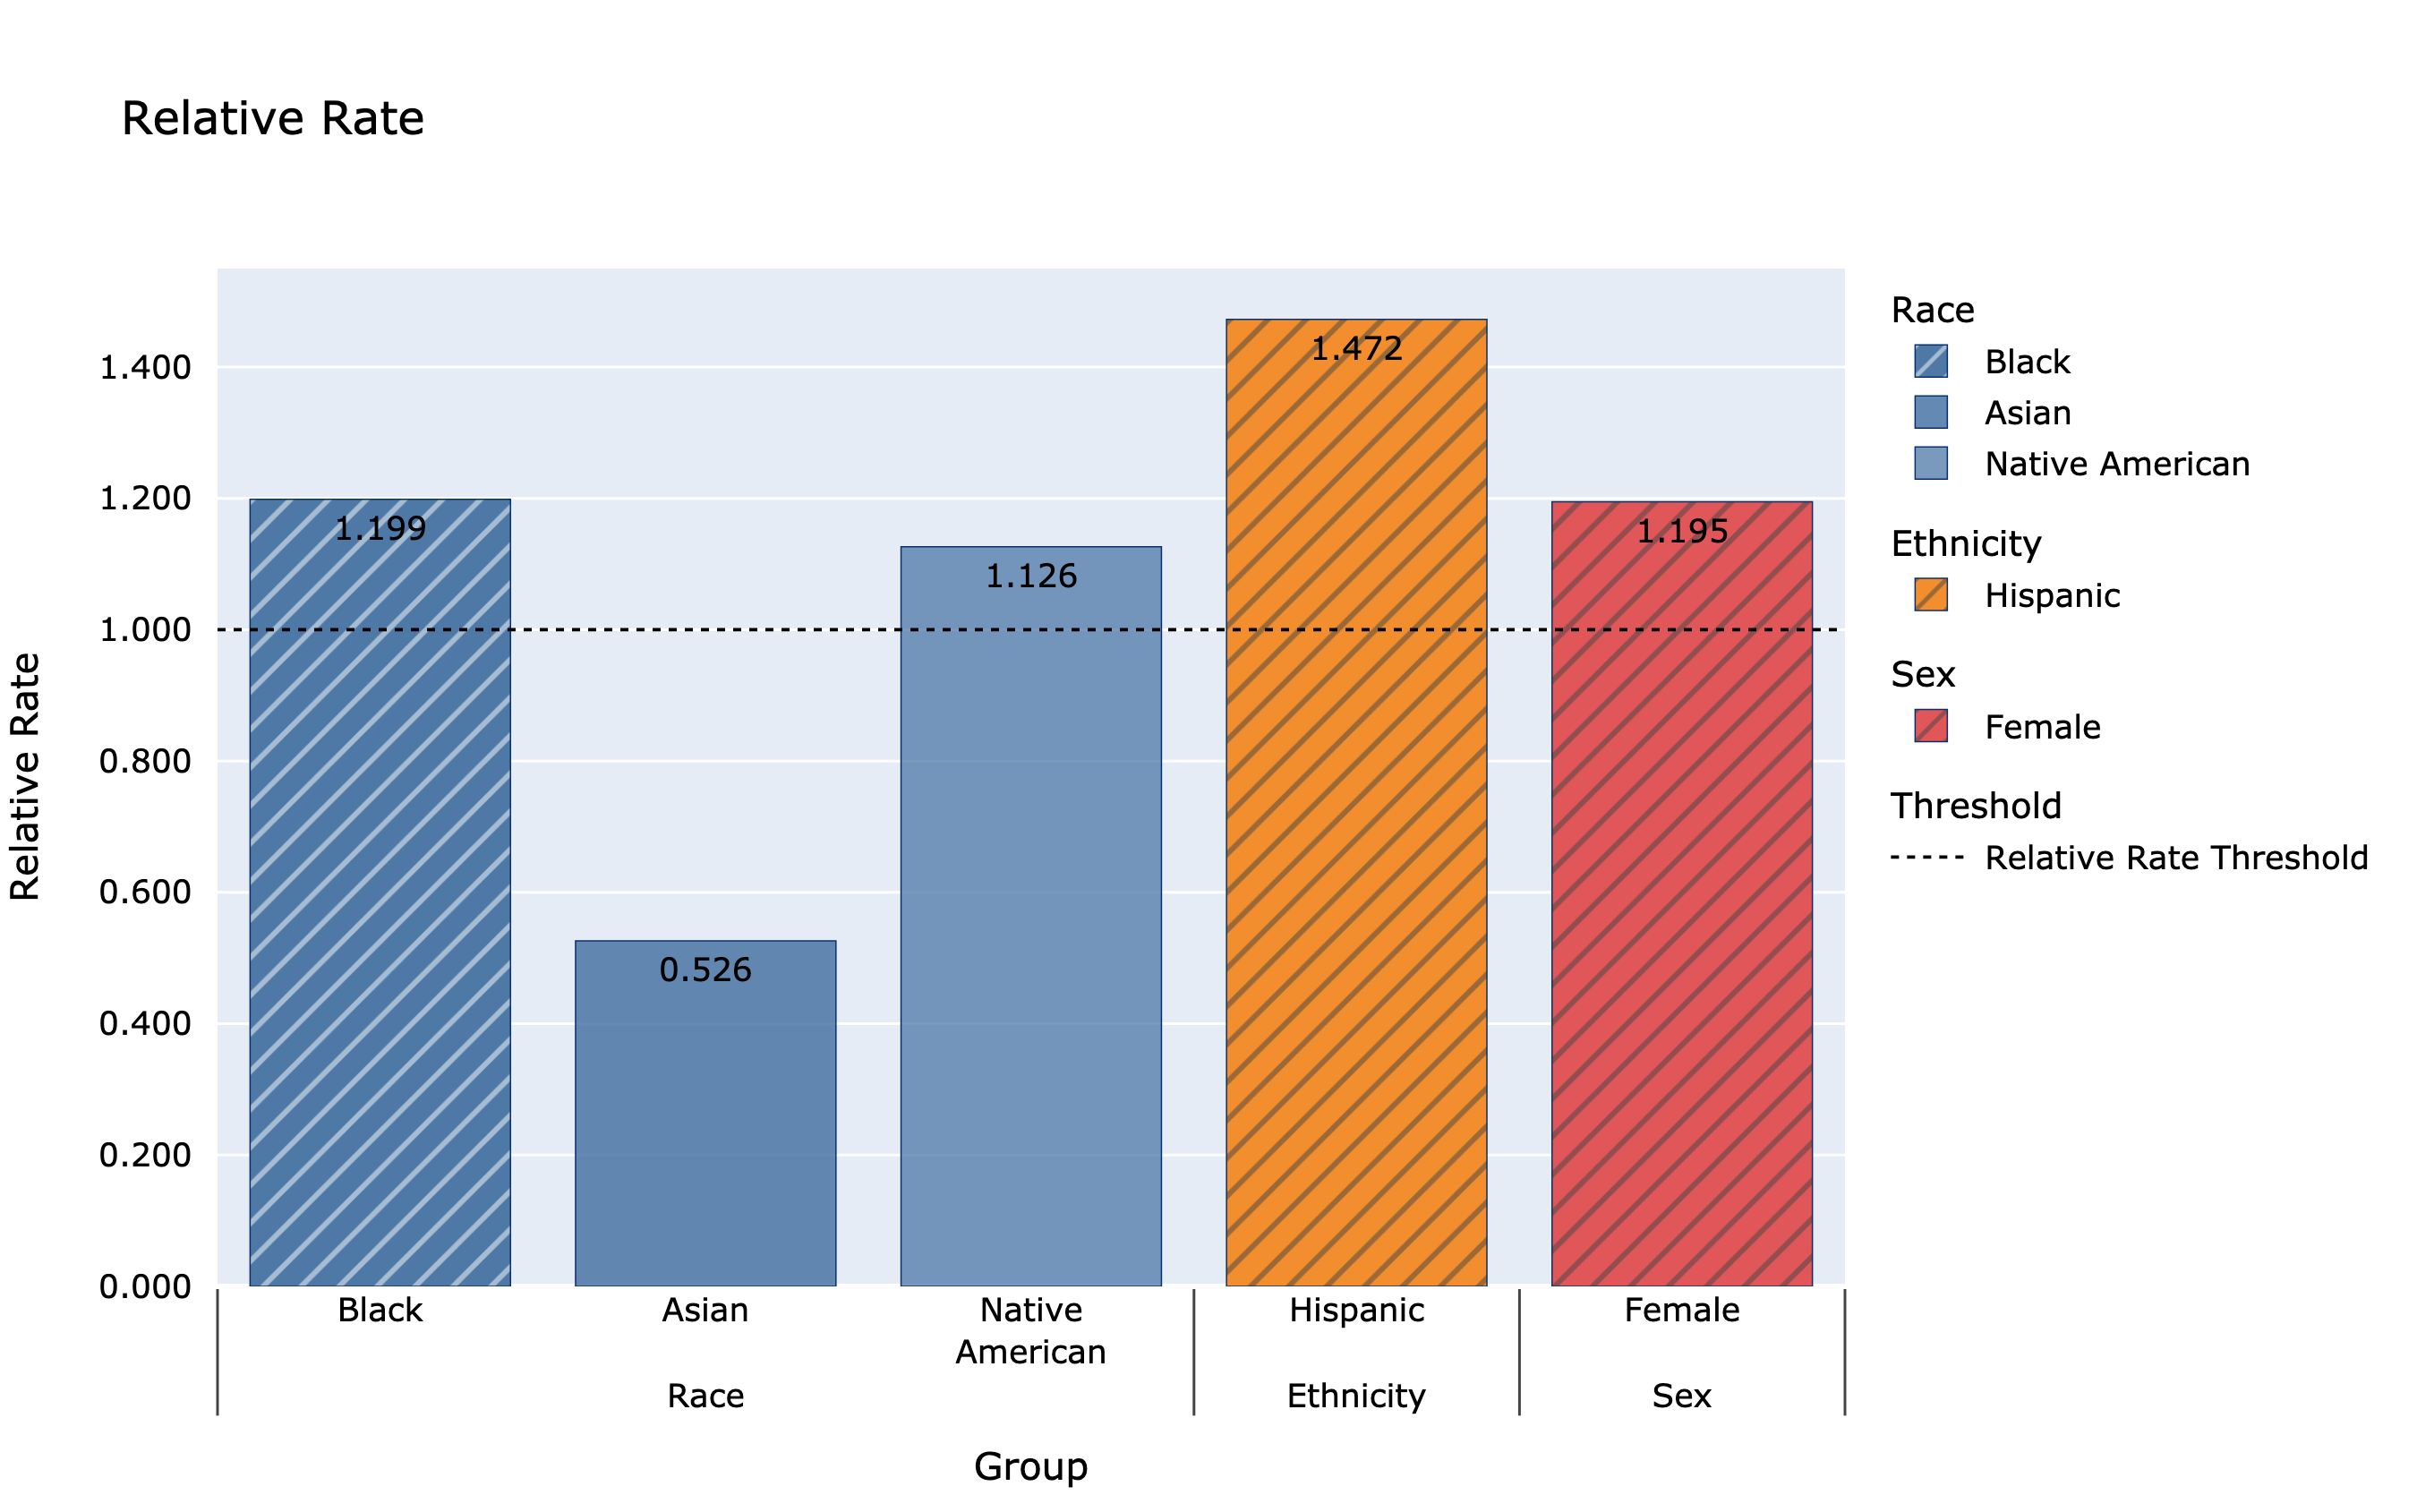

In [22]:
rr

## Custom Disparity Metric

We can recreate the AIR as an example of how custom disparity metrics
can be used. Many more advanced disparity metrics can benefit from the
framework and additional validation provided by the custom disparity
metric interface.

In [23]:
# Define a function for calculating perecent favorable.
def percent_favorable(outcome, sample_weight):
    return (outcome.mul(sample_weight, axis=0)).sum(
        axis=0, min_count=1
    ) / sample_weight.sum(axis=0, min_count=1)

## Disparity Calculation: Custom Disparity Metric

┌─────────────────────────────────────┬───────────────────────────────────────────────────────────────────────────┐
│ Protected Groups                    │ Black, Asian, Native American, Hispanic, Female                           │
│ Reference Groups                    │ White, White, White, Non-Hispanic, Male                                   │
│ Group Categories                    │ Race, Race, Race, Ethnicity, Sex                                          │
│ Metric                              │ percent_favorable                                                         │
│ Difference Calculation              │ reference_minus_protected                                                 │
│ Ratio Calculation                   │ protected_over_reference                                                  │
│ Affected Groups                     │ Black, Native American, Hispanic, Female                                  │
│ Affected Reference                  │ White, White, Non-Hispanic, Male                                          │
│ Affected Categories                 │ Race, Race, Ethnicity, Sex                                                │
└─────────────────────────────────────┴───────────────────────────────────────────────────────────────────────────┘

## Custom Disparity Metric Summary Table

\* Percent Missing: Ethnicity: 13.68%, Race: 13.56%, Sex: 46.88%

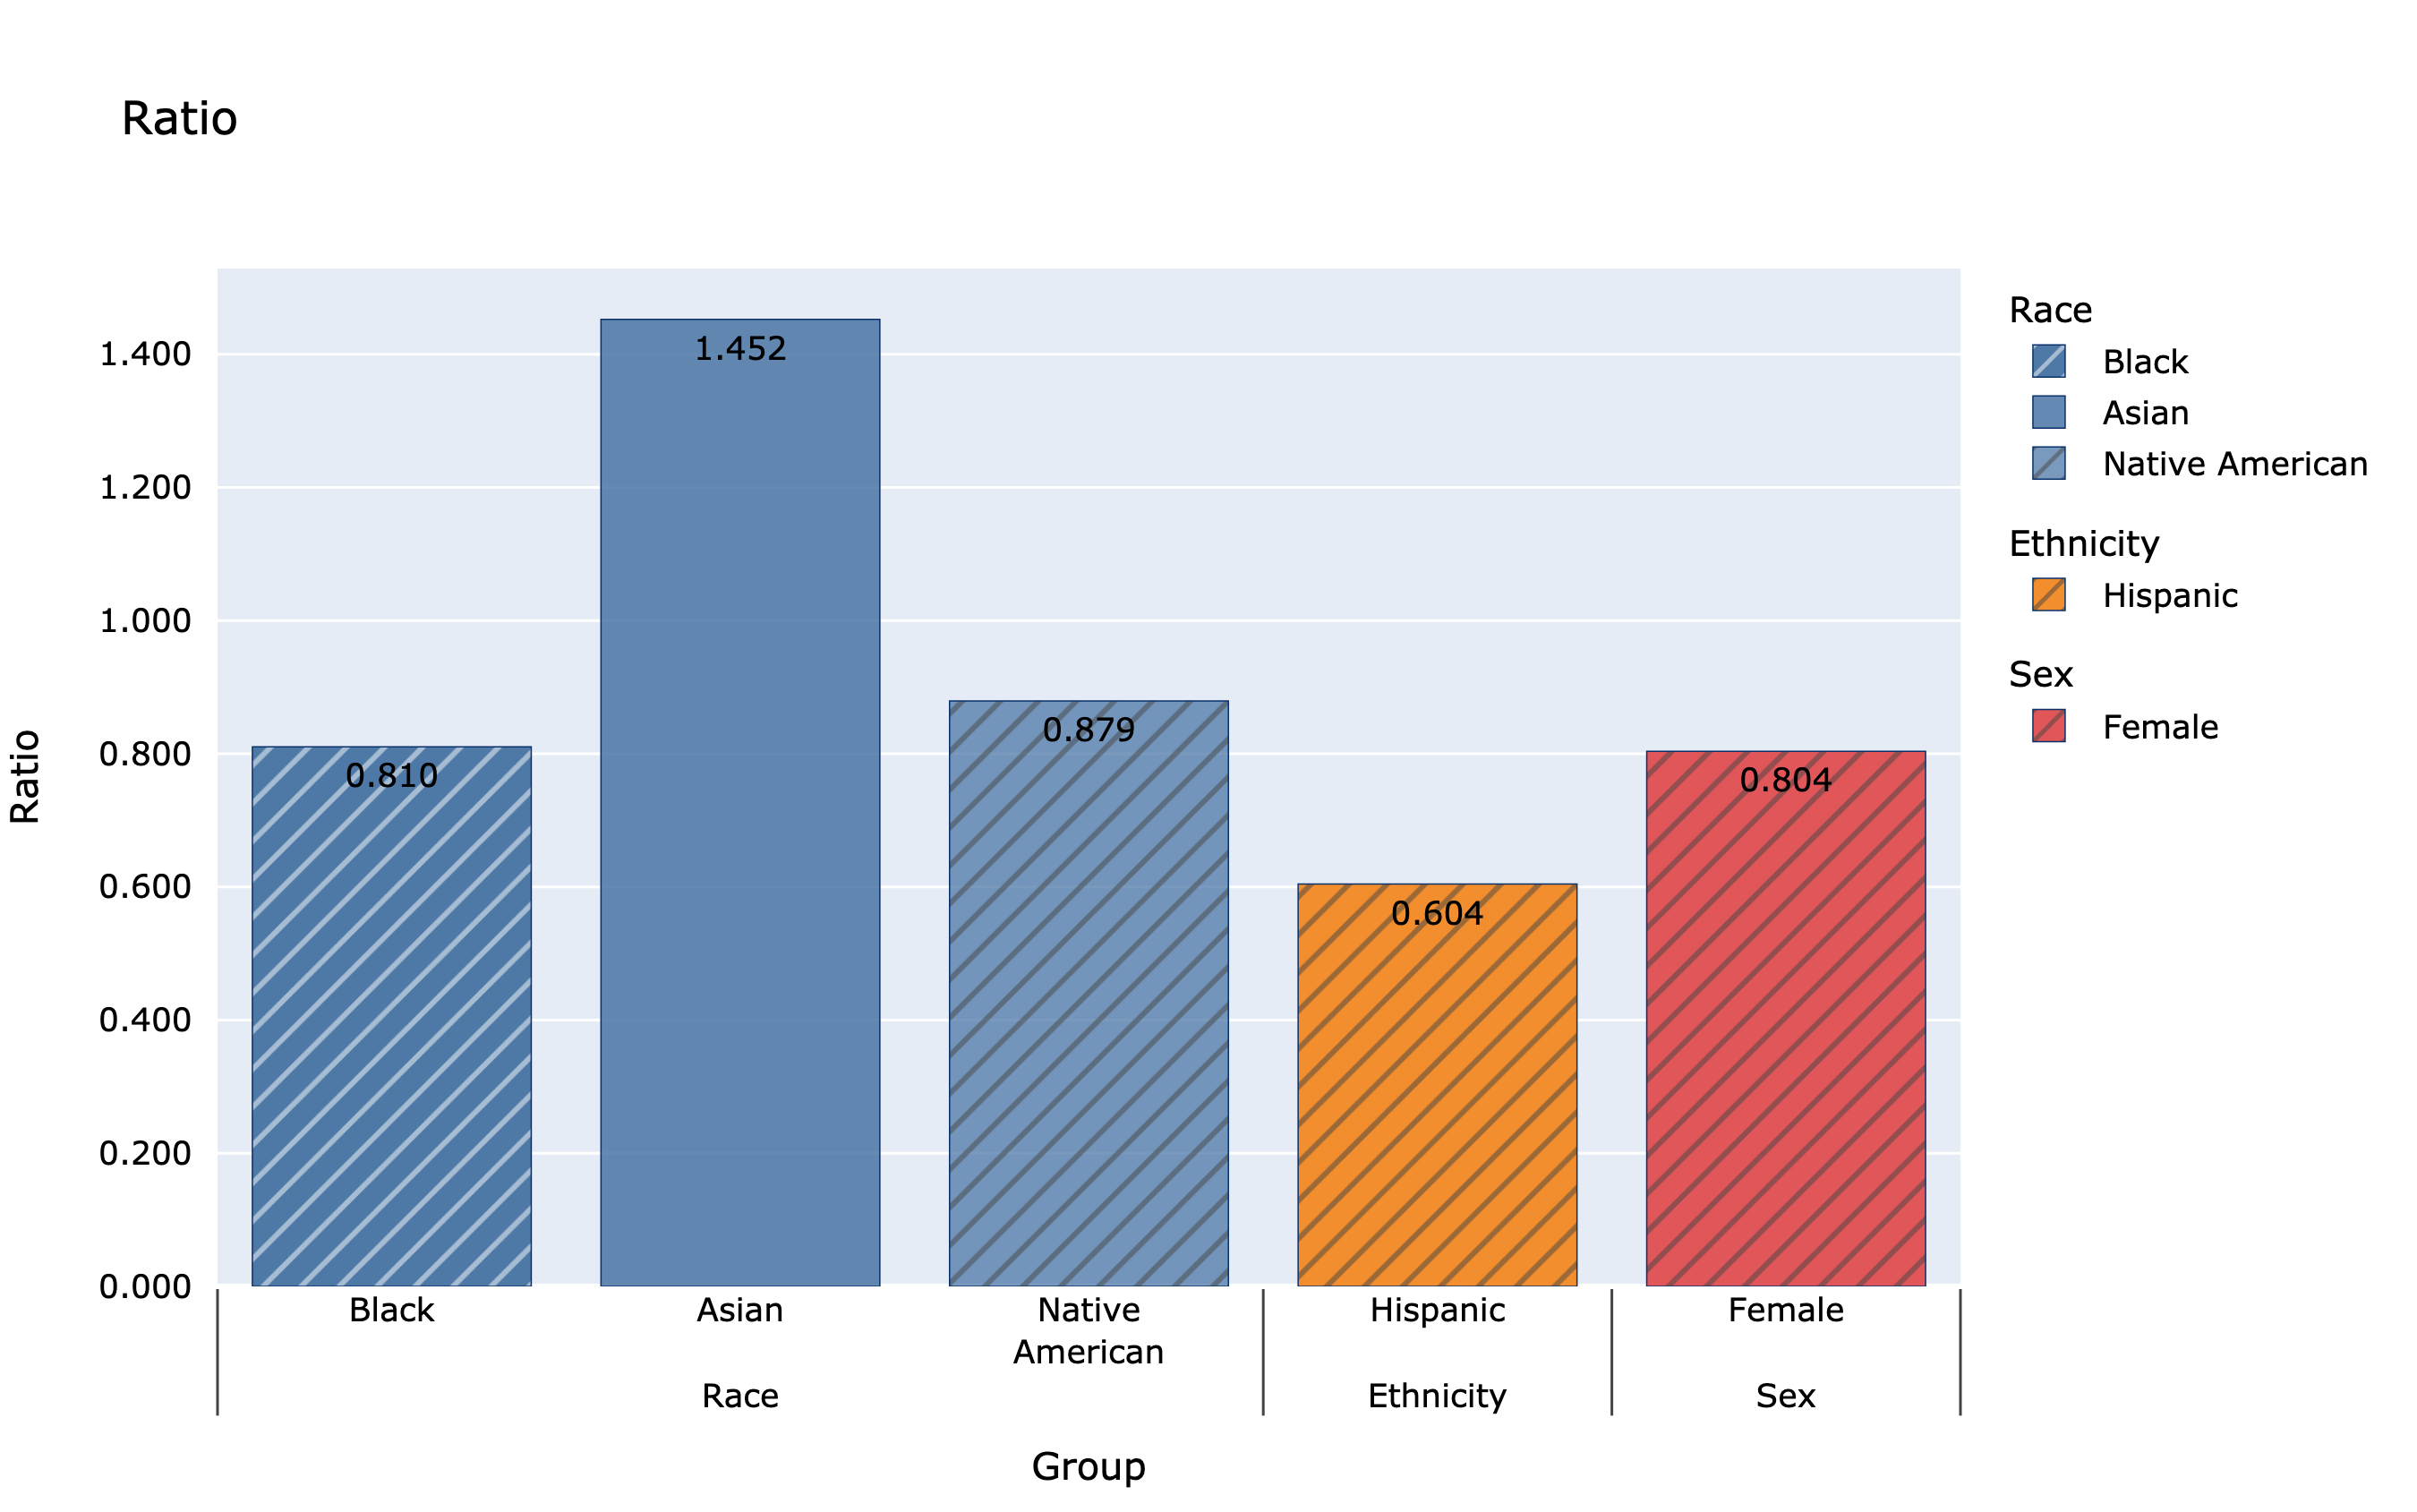

In [24]:
custom_air = sd.custom_disparity_metric(
    outcome=binary_outcome,
    metric=percent_favorable,
    difference_calculation=sd.types.DifferenceCalculation.REFERENCE_MINUS_PROTECTED,
    difference_threshold=lambda value: value > 0.0,
    ratio_calculation=sd.types.RatioCalculation.PROTECTED_OVER_REFERENCE,
    ratio_threshold=lambda value: value < 1.0,
    **reused_arguments,
)

custom_air

Note that the values from the custom disparity metric summary correspond
to those of the original AIR calculation.

In [25]:
pd.concat(
    (
        custom_air.summary_table["PERCENT FAVORABLE"],
        air.summary_table[sd.const.PERCENT_FAVORABLE],
    ),
    axis=1,
)

PERCENT FAVORABLE  Percent Favorable
Group                                                
Black                     0.414706           0.414706
Asian                     0.743119           0.743119
Native American           0.450000           0.450000
White                     0.511731           0.511731
Hispanic                  0.328740           0.328740
Non-Hispanic              0.544118           0.544118
Female                    0.400387           0.400387
Male                      0.498150           0.498150

In [26]:
pd.concat(
    (
        custom_air.summary_table[sd.const.RATIO],
        air.summary_table[sd.const.AIR_VALUES],
    ),
    axis=1,
)

Ratio       AIR
Group                              
Black            0.810399  0.810399
Asian            1.452169  1.452169
Native American  0.879369  0.879369
White                 NaN       NaN
Hispanic         0.604171  0.604171
Non-Hispanic          NaN       NaN
Female           0.803747  0.803747
Male                  NaN       NaN

## Confusion Matrix Metrics

SolasAI-provides ready-made implementations of confusion matrix metrics
by wrapping around the custom disparity metric.

In [27]:
(
    sd.false_discovery_rate,
    sd.false_negative_rate,
    sd.false_positive_rate,
    sd.precision,
    sd.true_negative_rate,
    sd.true_positive_rate,
)

(<cyfunction false_discovery_rate at 0x12f4d6790>,
 <cyfunction false_negative_rate at 0x12f814c70>,
 <cyfunction false_positive_rate at 0x12f8261e0>,
 <cyfunction precision at 0x12f83cad0>,
 <cyfunction true_negative_rate at 0x12f8c9a00>,
 <cyfunction true_positive_rate at 0x12f8d5ee0>)

## Disparity Calculation: Precision

┌─────────────────────────────────────┬───────────────────────────────────────────────────────────────────────────┐
│ Protected Groups                    │ Black, Asian, Native American, Hispanic, Female                           │
│ Reference Groups                    │ White, White, White, Non-Hispanic, Male                                   │
│ Group Categories                    │ Race, Race, Race, Ethnicity, Sex                                          │
│ Metric                              │ precision_score                                                           │
│ Difference Calculation              │ reference_minus_protected                                                 │
│ Difference Threshold                │ 0.0                                                                       │
│ Ratio Calculation                   │ protected_over_reference                                                  │
│ Ratio Threshold                     │ 1.0                                                                       │
│ Affected Groups                     │ Black, Native American, Hispanic, Female                                  │
│ Affected Reference                  │ White, White, Non-Hispanic, Male                                          │
│ Affected Categories                 │ Race, Race, Ethnicity, Sex                                                │
└─────────────────────────────────────┴───────────────────────────────────────────────────────────────────────────┘

## Precision Summary Table

\* Percent Missing: Ethnicity: 0.00%, Race: 0.00%, Sex: 0.00%

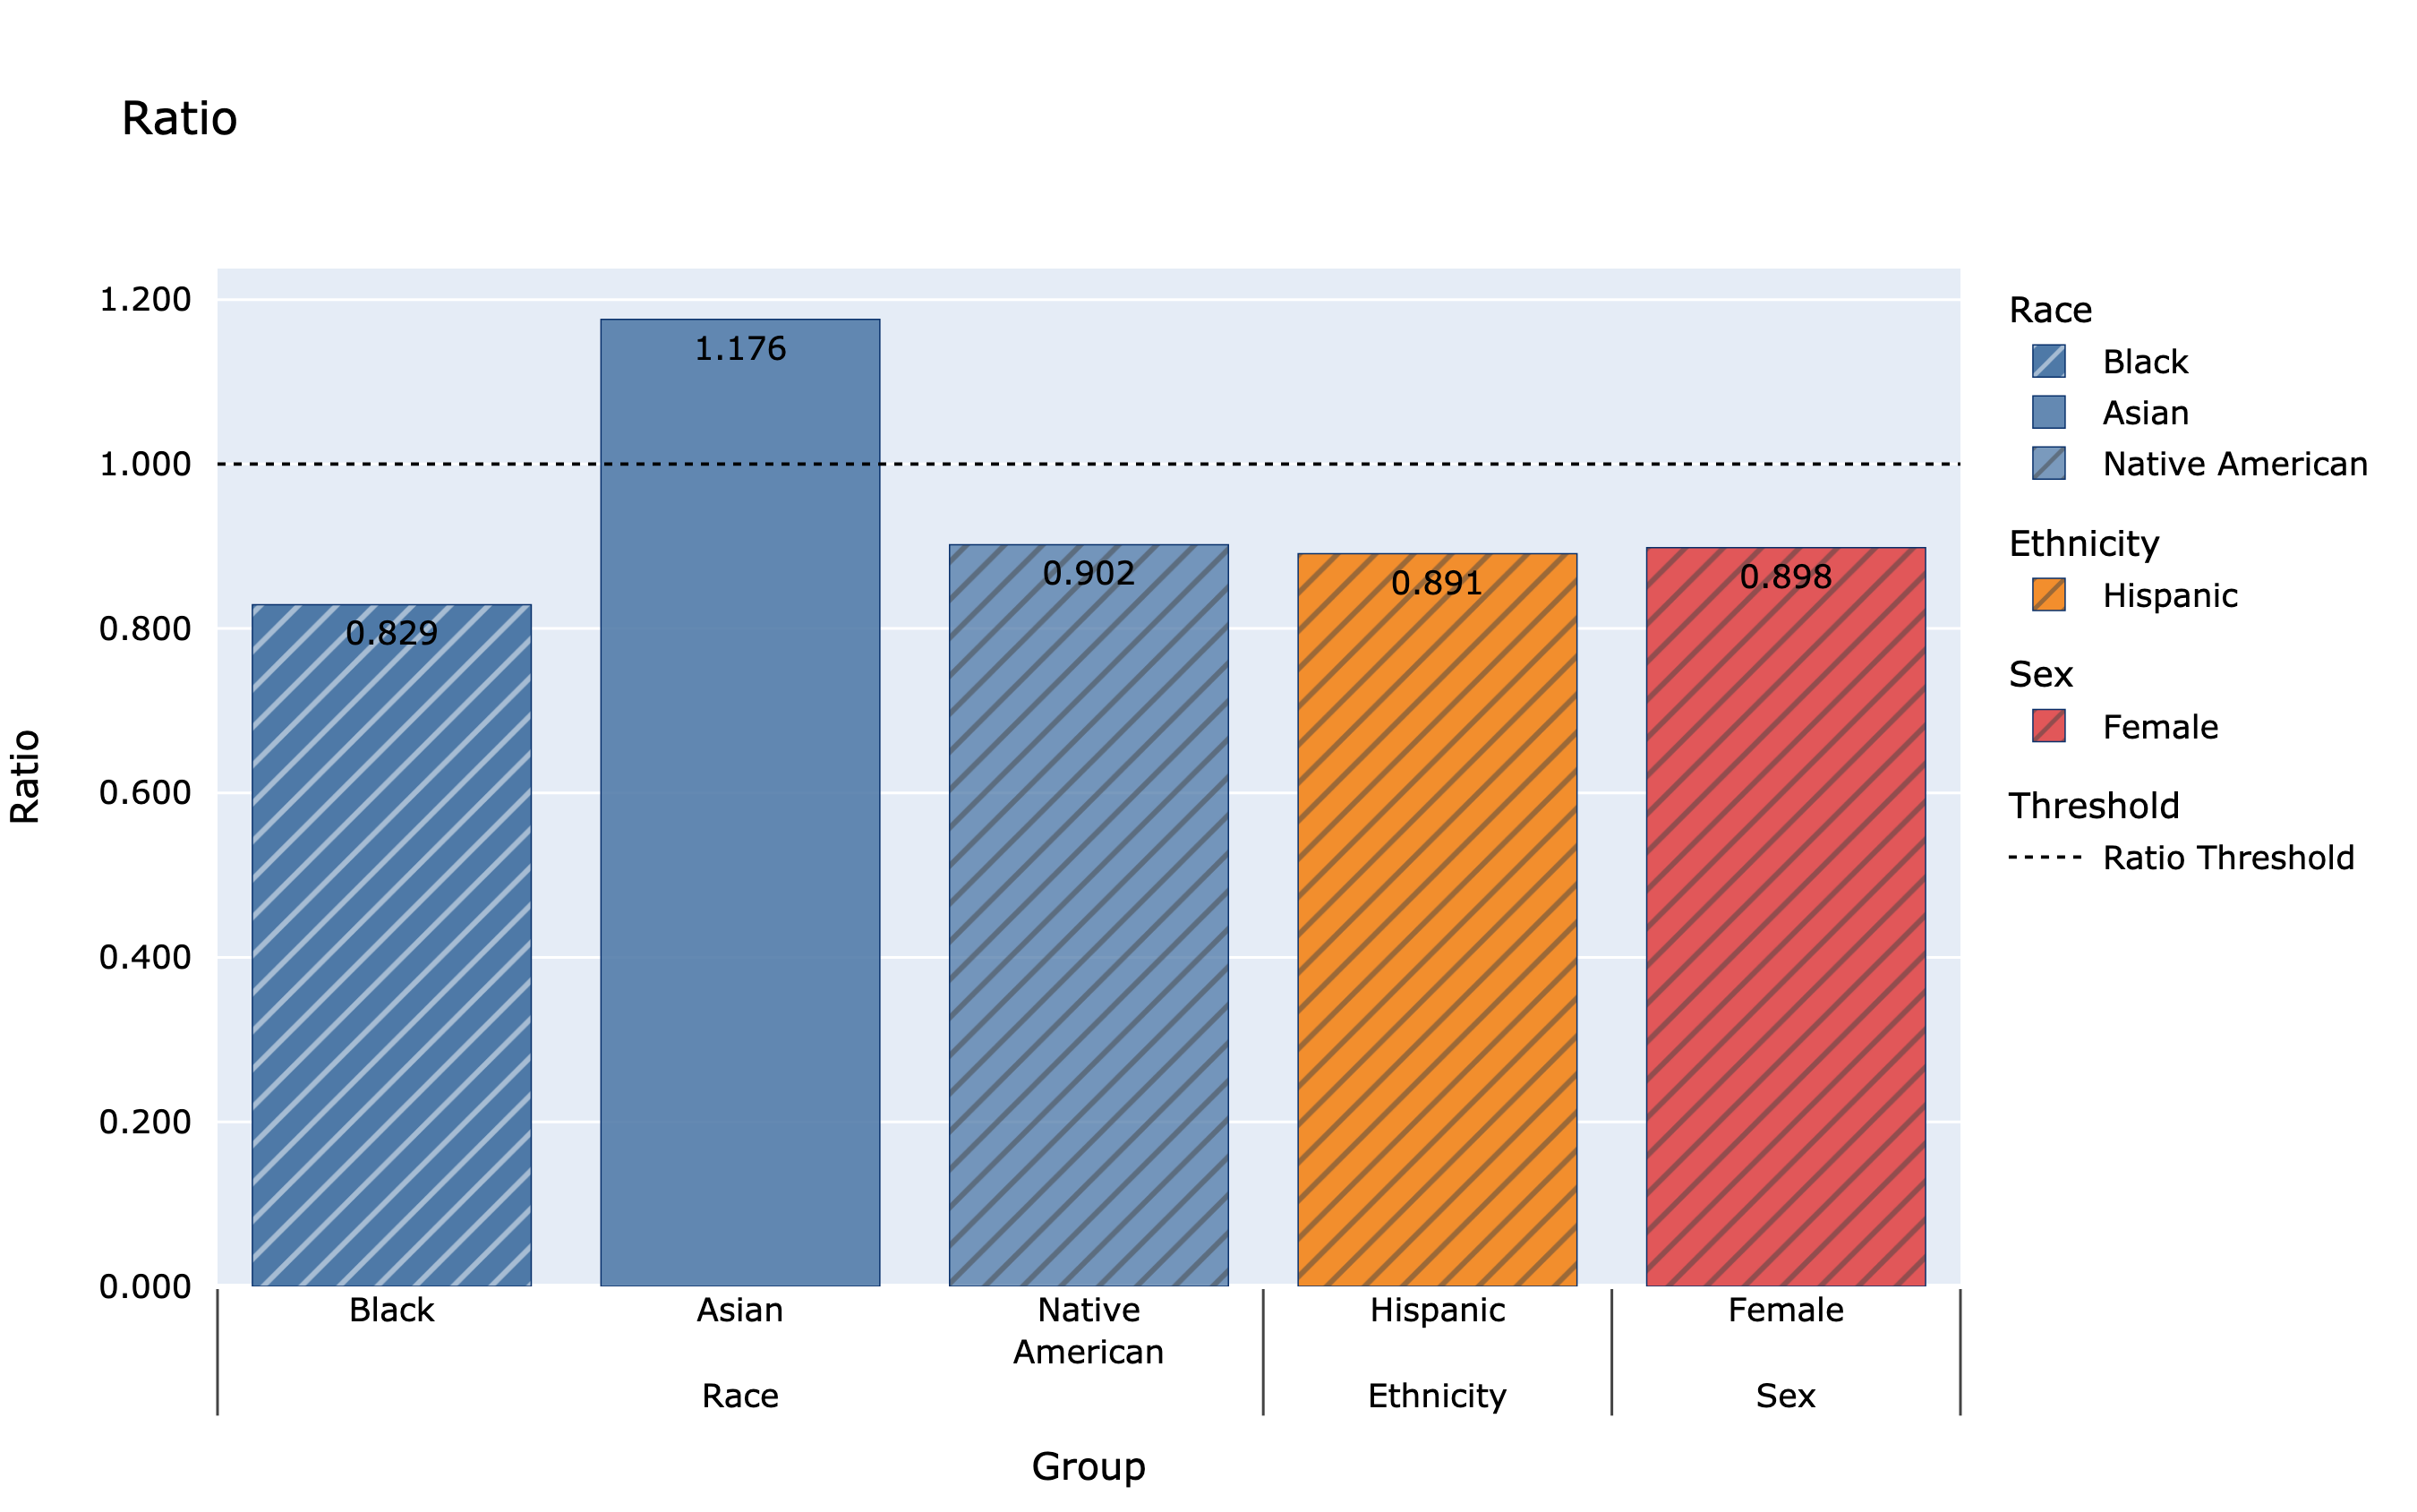

In [28]:
precision_arguments = reused_arguments.copy()
precision_arguments["group_data"] = precision_arguments["group_data"].fillna(0.0)
precision = sd.precision(
    outcome=binary_outcome,
    label=binary_label,
    ratio_threshold=1.0,
    difference_threshold=0.0,
    **precision_arguments,
)
precision

``sd.precision`` is essentially a convience wrapper for the
following call to the custom disparity metric.

## Disparity Calculation: Custom Disparity Metric

┌─────────────────────────────────────┬───────────────────────────────────────────────────────────────────────────┐
│ Protected Groups                    │ Black, Asian, Native American, Hispanic, Female                           │
│ Reference Groups                    │ White, White, White, Non-Hispanic, Male                                   │
│ Group Categories                    │ Race, Race, Race, Ethnicity, Sex                                          │
│ Metric                              │ precision                                                                 │
│ Difference Calculation              │ reference_minus_protected                                                 │
│ Ratio Calculation                   │ protected_over_reference                                                  │
│ Affected Groups                     │ Black, Native American, Hispanic, Female                                  │
│ Affected Reference                  │ White, White, Non-Hispanic, Male                                          │
│ Affected Categories                 │ Race, Race, Ethnicity, Sex                                                │
└─────────────────────────────────────┴───────────────────────────────────────────────────────────────────────────┘

## Custom Disparity Metric Summary Table

\* Percent Missing: Ethnicity: 0.00%, Race: 0.00%, Sex: 0.00%

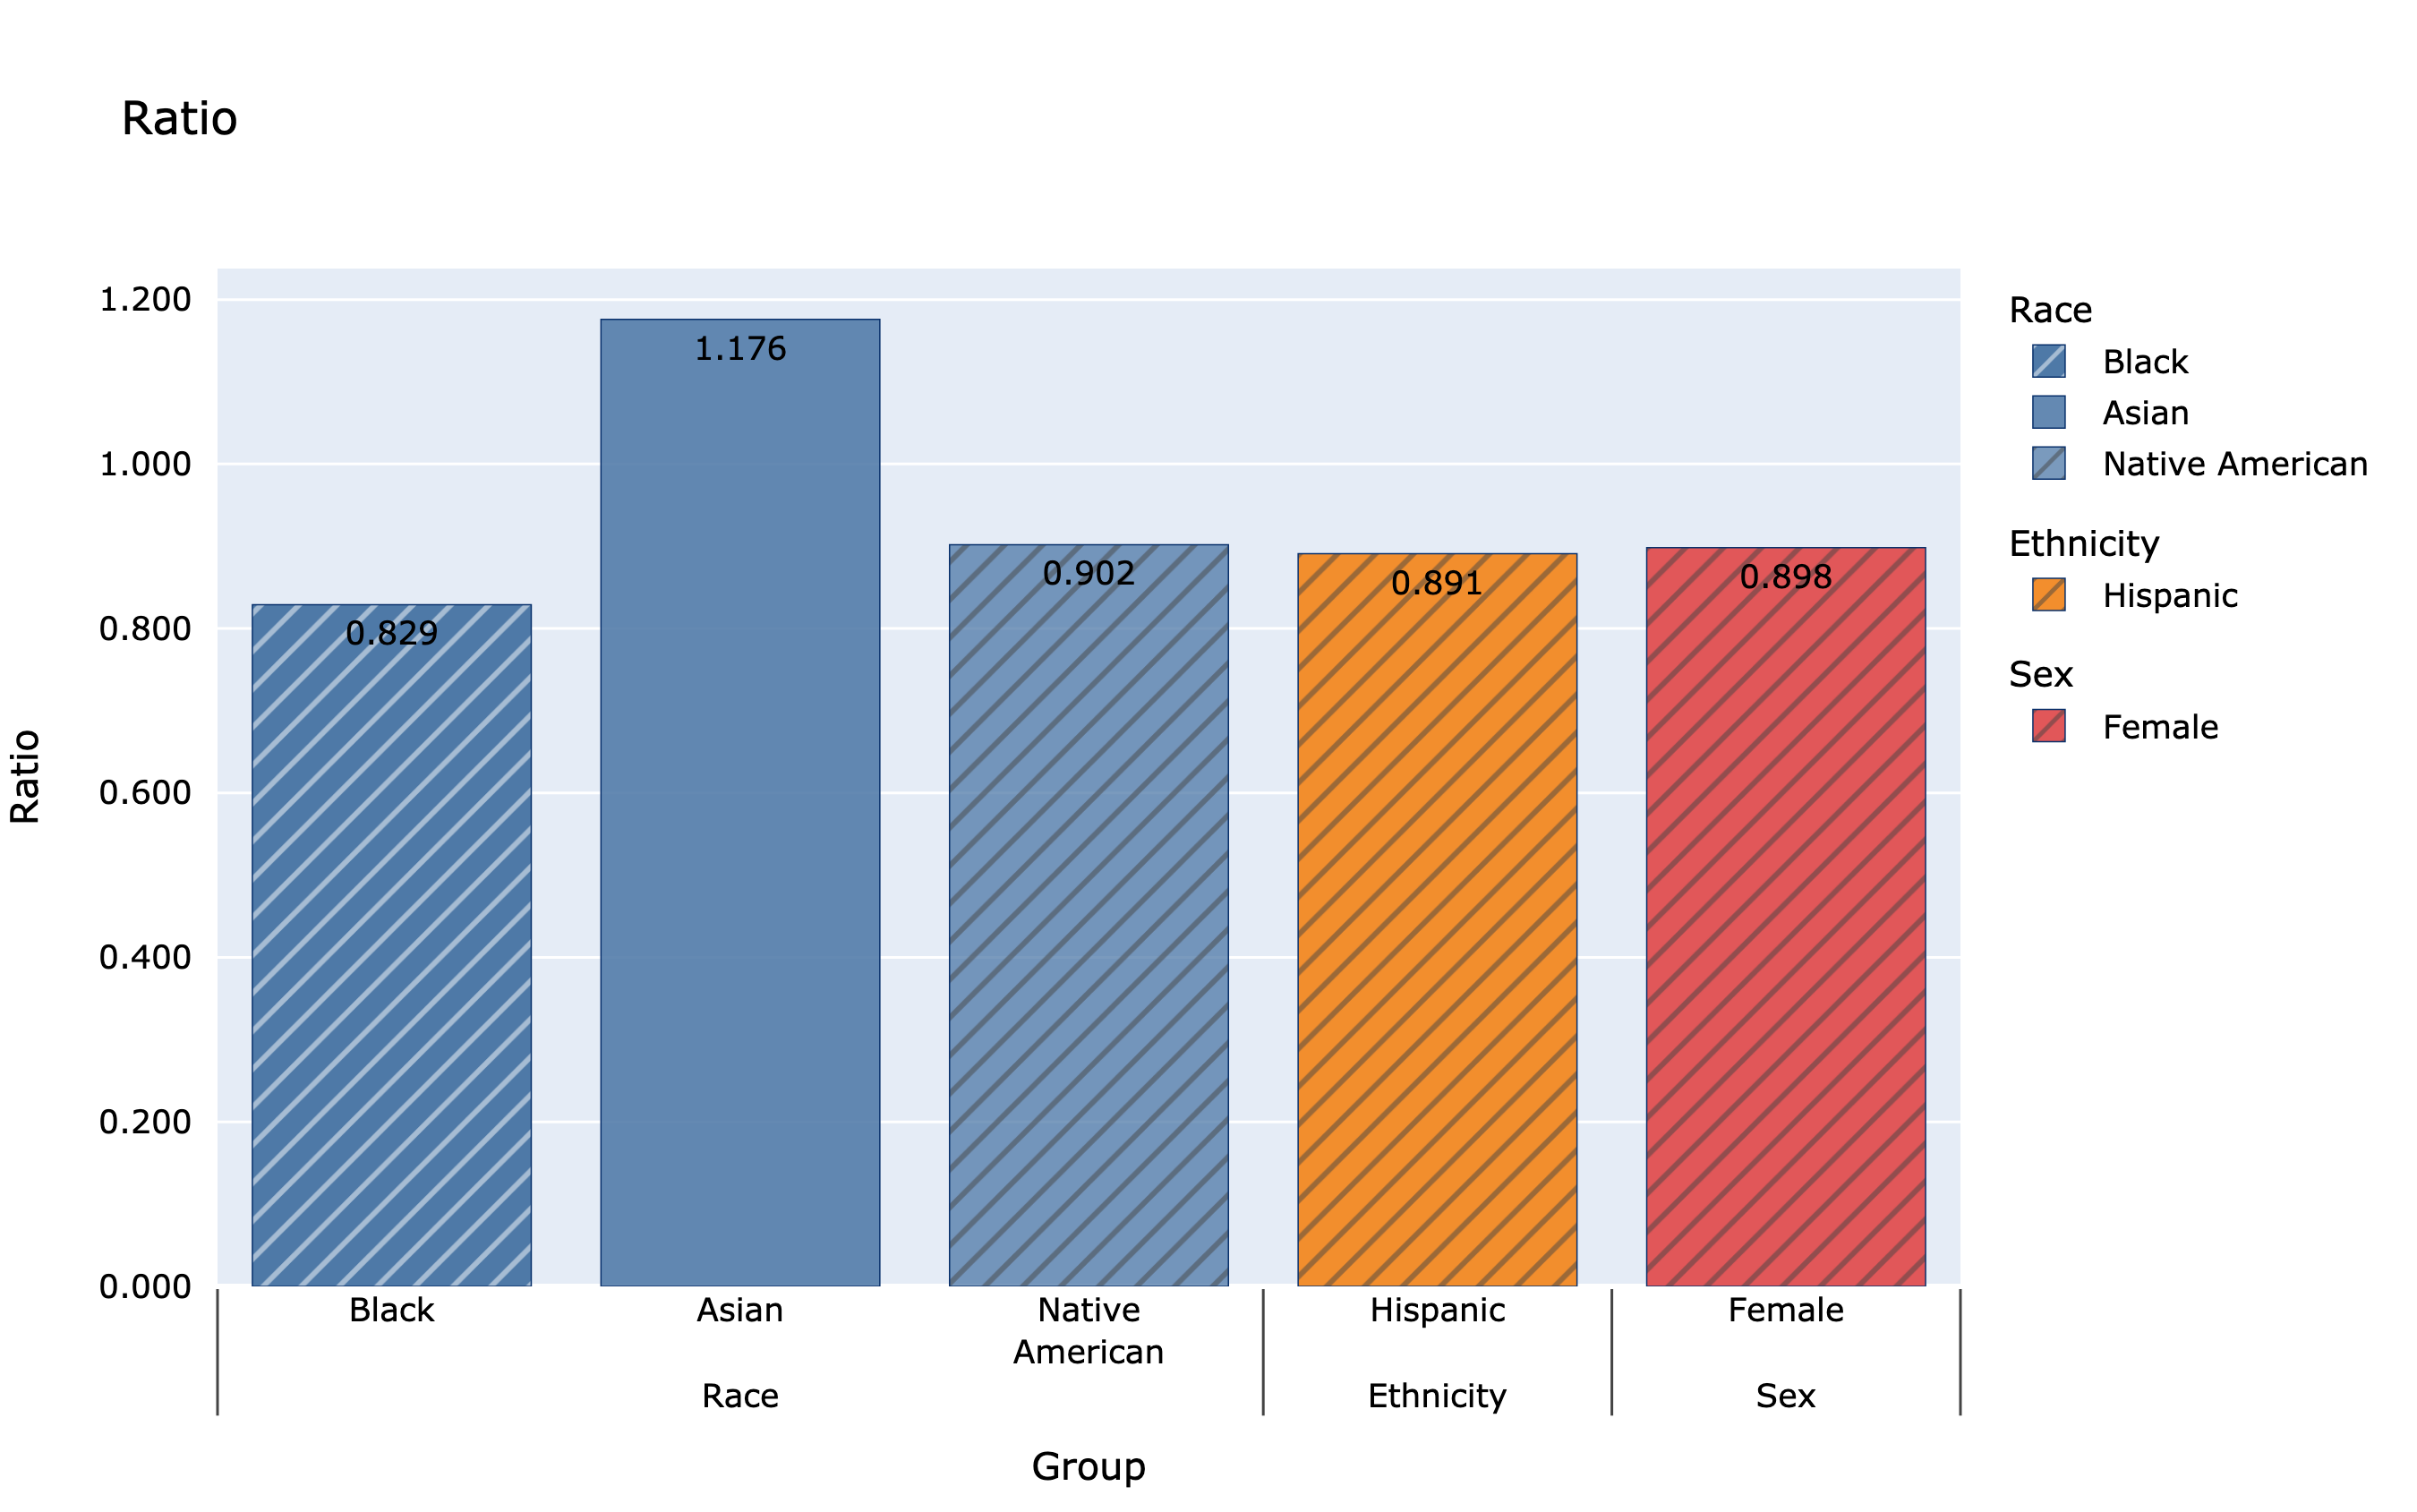

In [29]:
def precision(y_true, y_pred, sample_weight):
    from sklearn.metrics import confusion_matrix

    tn, fp, fn, tp = confusion_matrix(
        y_true=y_true,
        y_pred=y_pred,
        sample_weight=sample_weight,
    ).ravel()

    return tp / (tp + fp)


sd.custom_disparity_metric(
    outcome=binary_outcome,
    metric=precision,
    label=binary_label,
    difference_calculation=sd.types.DifferenceCalculation.REFERENCE_MINUS_PROTECTED,
    difference_threshold=lambda difference: difference > 0.0,
    ratio_calculation=sd.types.RatioCalculation.PROTECTED_OVER_REFERENCE,
    ratio_threshold=lambda ratio: ratio < 1.0,
    **precision_arguments,
)